# 0.0 Imports

## Import Librarys and Methods

In [1]:
import math
import time
import pandas as pd
import numpy  as np
import random
import pickle
import datetime
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from scipy                import stats  as ss
from boruta               import BorutaPy
from matplotlib           import gridspec
from matplotlib           import pyplot as plt
from IPython.display      import Image
from IPython.core.display import HTML


from sklearn.ensemble      import RandomForestRegressor
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso

## Helper Functions

### Cross Validation Functions

In [2]:
# Cross validation - ML
def cross_validation(x_training, kfold, model_name, model, verbose = False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('\nKFold Number:{}'.format(k))
        # Start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days = k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days = (k-1)*6*7)
        
        # Filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]
        
        # Training and validation dataset
        # Traning
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']

        # Validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = model.predict(xvalidation)

        # Performance

        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # Store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)}, index = [0])

In [3]:
# Functions of ML
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )


def mean_absolute_percentage_error(Y, yhat):
    return np.mean(np.abs((Y - yhat) / Y))

def ml_error(model_name, Y, yhat):
    mae = mean_absolute_error(Y, yhat)
    mape = mean_absolute_percentage_error(Y, yhat)
    rmse = np.sqrt(mean_squared_error(Y, yhat))
    
    return pd.DataFrame({'Model Name': model_name, 
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse}, index =[0])

def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

### Visual References

In [4]:
# ZOOM IN CELL JUPYTER
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# SHOW ALL COLUMNS
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# THEME GRAPHS
sns.set_theme()
sns.set(rc={'figure.figsize':(25,19)})

# IGNORE ERRORS WARNINGS
warnings.filterwarnings('ignore')

### Loading Data

In [5]:
df_sales_raw = pd.read_csv('Data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('Data/store.csv', low_memory=False)

# DATASET MERGE
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on='Store')

# SAMPLE OF DATA
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
780910,81,3,2013-07-31,8299,612,1,1,0,1,a,a,2370.0,3.0,2011.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


# 1.0 Data Description

In [6]:
# Make copy of the dataset raw.
df1 = df_raw.copy()

## 1.1 Rename Columns

In this section, w'll change the name of columns to the snakecase structure.

In [7]:
# See all columns names
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
# Creating a variable to receive the current name of the columns

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance',  'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

# Function snakecase to change the names
snakecase = lambda x: inflection.underscore(x)

# Rename
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

# Seeing changes
df1. columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data dimensions

Checking number of rows and columns

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Type

Let's see the type of the data and convert if necessary

In [10]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
# Converting data type

df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA's

Applying **isna**, we'll see that the dataset have some missing values, which necessity be worked

In [12]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA's

Working with the missing values.

In [13]:
# Catch the maximum value in competition distance.
df1['competition_distance'].max()

75860.0

In [14]:
# Applying 200000 in Competition distance if the feature is null.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)


# Extract the mounth of the date to missing competition open since month.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

# Extract the mounth of the date to missing competition open since year.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

# Extract the mounth of the date to missing promo since week.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

# Extract the mounth of the date to missing promo since year.
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

# Creating dict to receive the abbreviated month
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x ['promo_interval'].split(',') else 0, axis = 1)

In [15]:
# Seeing the changes in missing values.
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6 Change Types

Change type of the data.

In [16]:
# See the type of the data.
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
# Change types
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [18]:
# Check changes
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7 Descriptive Statistical

Descriptive Statistical of the data.

In [19]:
# Sorting out the data through type.
num_attributes = df1.select_dtypes(include=['int64', 'float64', 'int32']) 
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'int32', 'datetime64']) 

### 1.7.1 Numerical Attributes

Let's see some descriptive statistical of the numerical attributes. Here we'll see basic statistical, like: Mean, Median, Dispersion, Minimum, Maximum, Range, Skew and Kurtosis

In [20]:
# Mean
mean = pd.DataFrame(num_attributes.apply(np.mean)).T

# Median
median = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion
dispersion = pd.DataFrame(num_attributes.apply(np.std)).T

# Minimu,
minimo = pd.DataFrame(num_attributes.apply(min)).T

# Maximum
maximo = pd.DataFrame(num_attributes.apply(max)).T

# Range
rangex = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T

# Skew
skew = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T

# Kurtosis
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concat the statistical above
metricas = pd.concat([minimo, maximo, rangex, mean, median, dispersion, skew, kurtosis]).T.reset_index()
metricas

# Assigning name in the statisticals.
metricas.columns = ['attributes', 'min', 'max', 'rangex', 'mean', 'median', 'dispersion', 'skew', 'kurtosis']
metricas

,attributes,min,max,rangex,mean,median,dispersion,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


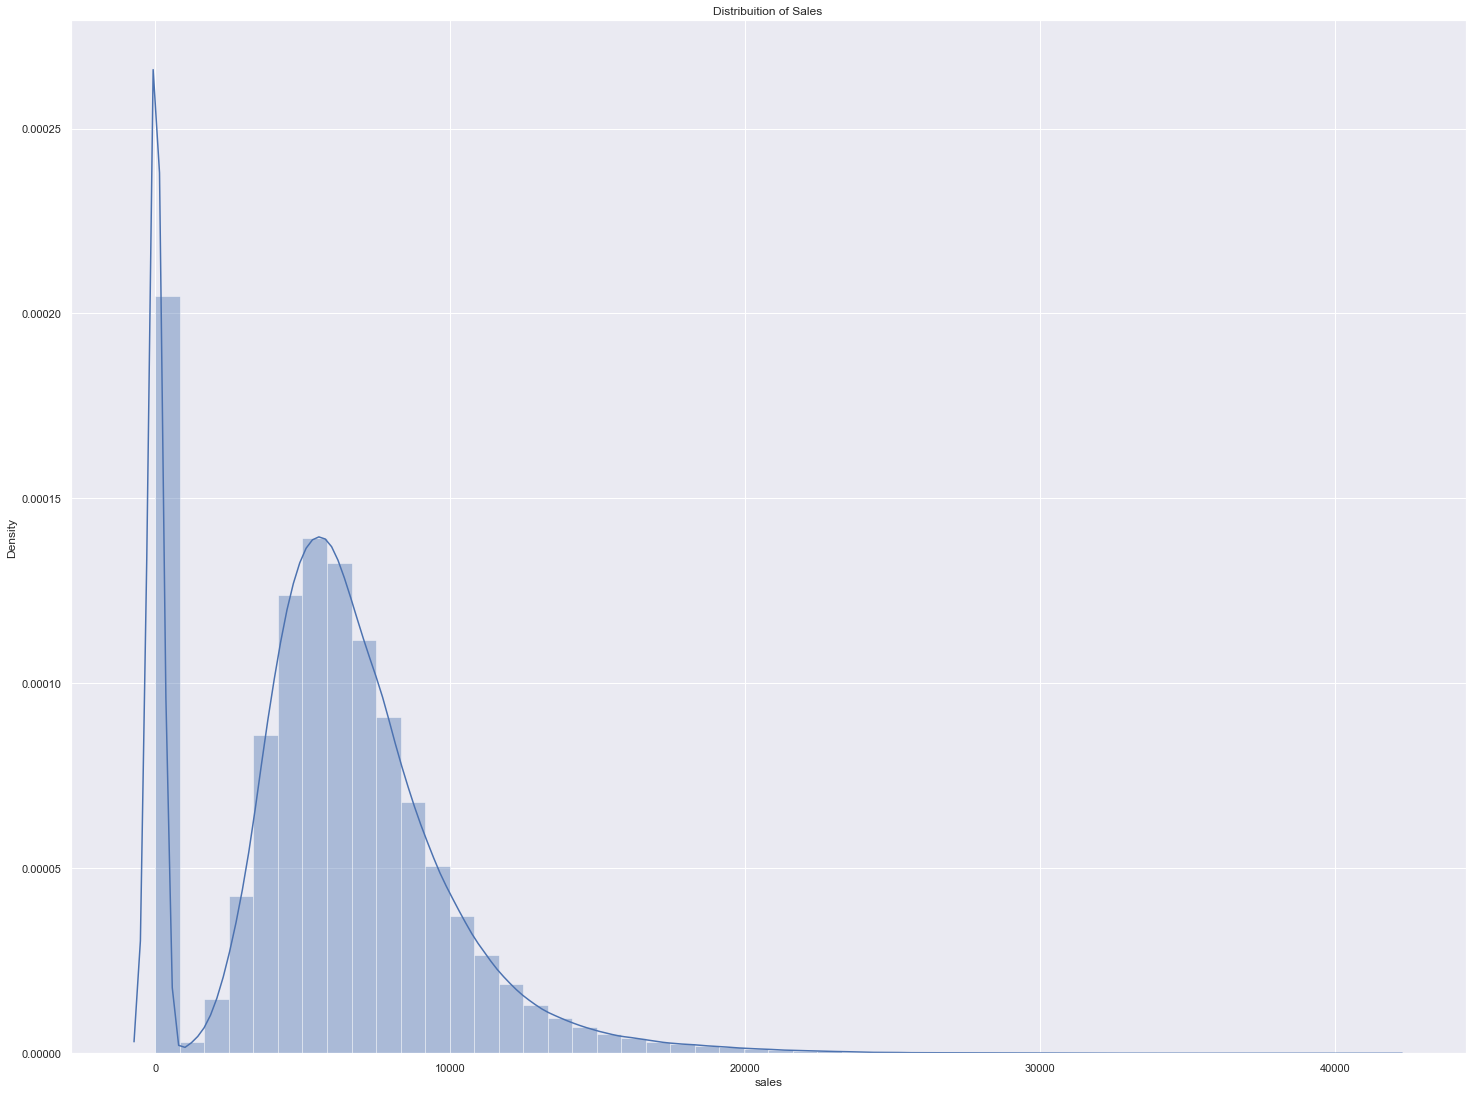

In [21]:
# Seeing distribuitation
sns.distplot(df1['sales']).set_title("Distribuition of Sales");

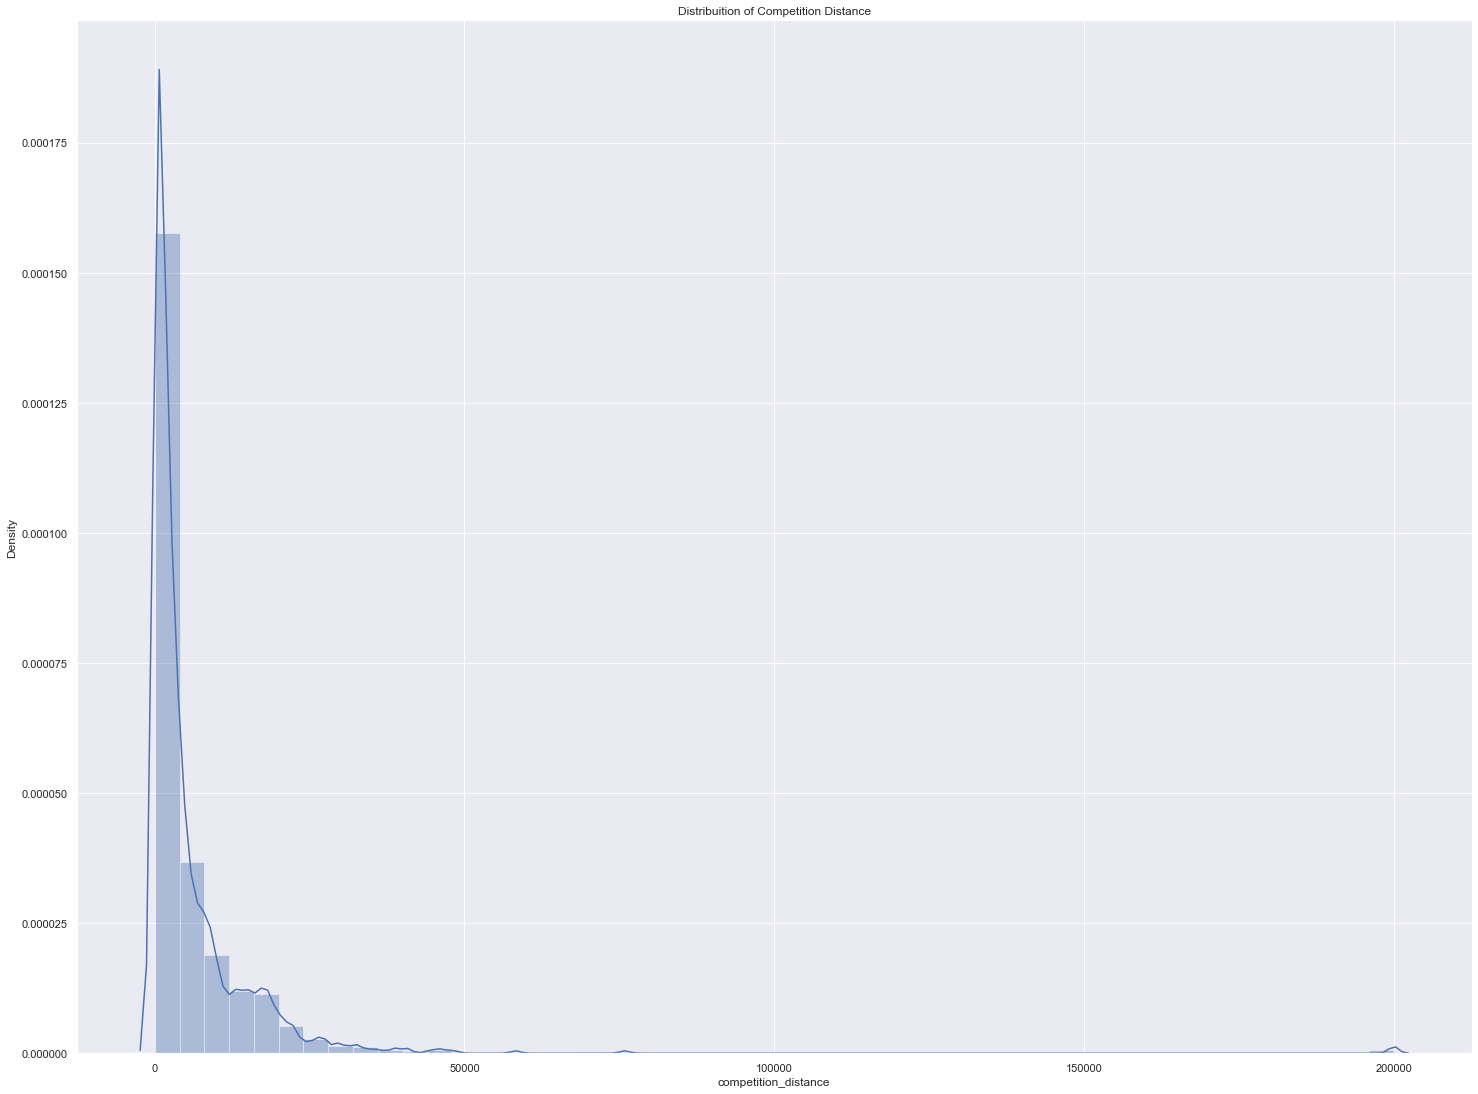

In [22]:
# Seeing distribuitation
sns.distplot(df1['competition_distance']).set_title("Distribuition of Competition Distance");

### 1.7.2 Categorical Attributes

Let's see some descriptive statistical of the categorical attributes.

In [23]:
# See the categorical attributes
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

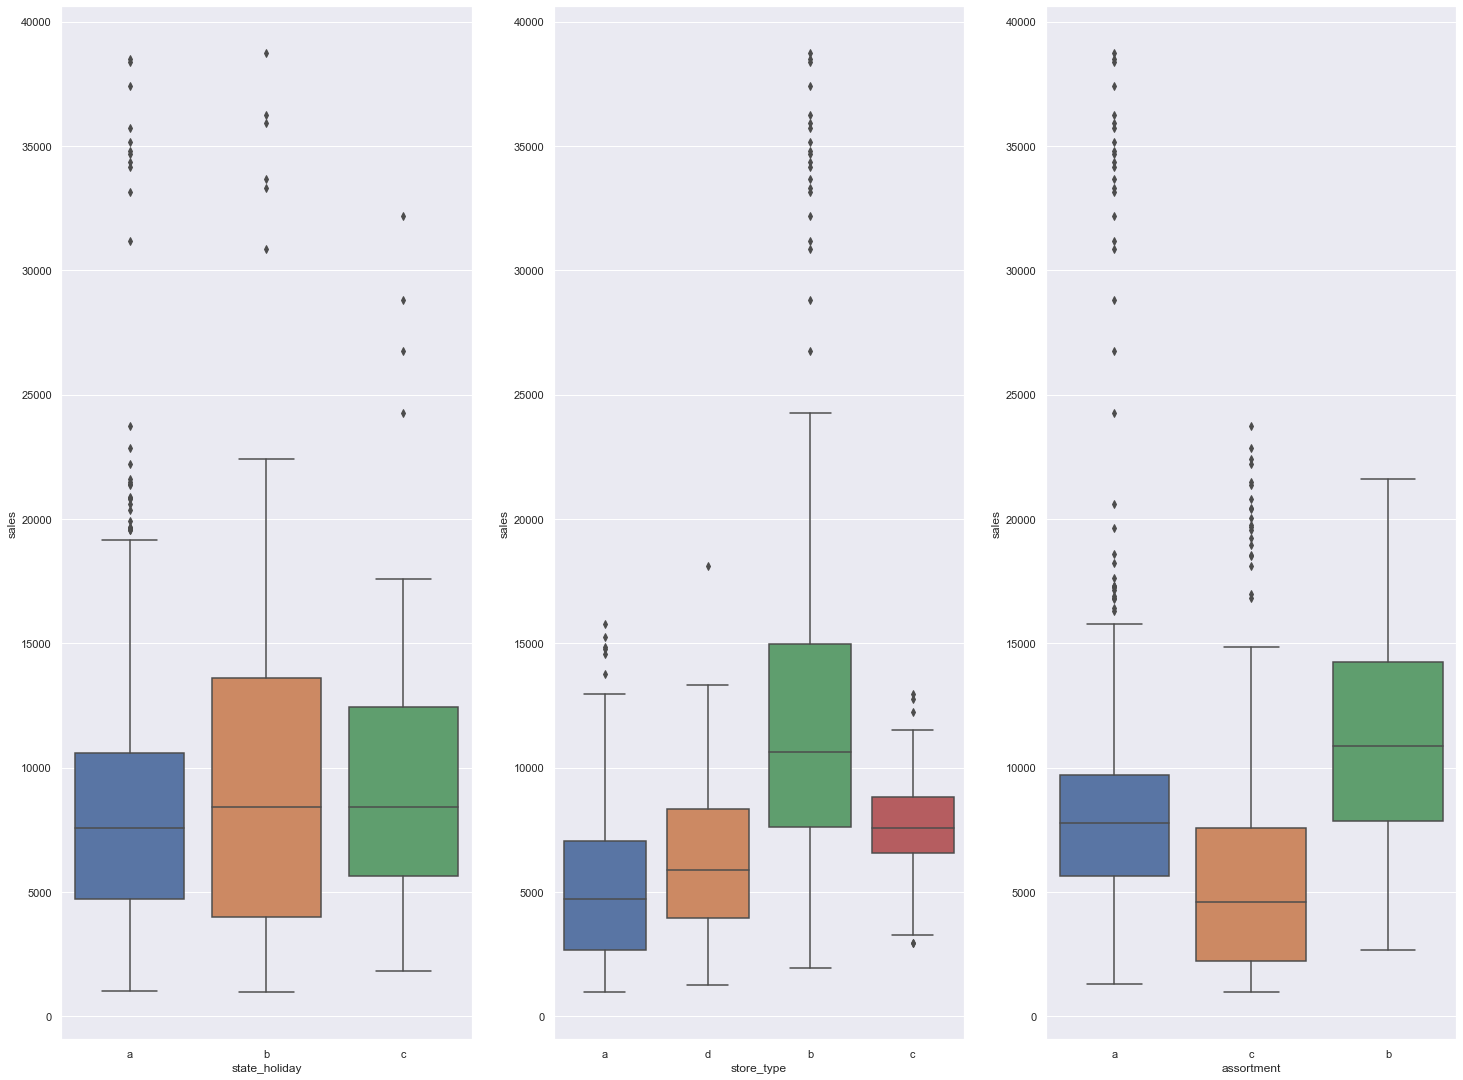

In [24]:
# Creating bloxpot to see how the categorical attributes are distributed.

plt.subplot(1, 3, 1)
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
sns.boxplot(x = 'state_holiday', y ='sales', data = aux1);

plt.subplot(1, 3, 2)
sns.boxplot(x = 'store_type', y ='sales', data = aux1);

plt.subplot(1, 3, 3)
sns.boxplot(x = 'assortment', y ='sales', data = aux1);

# 2.0 Feature Engineering

In [25]:
# Copy of the data of the 1.0 section. 
df2 = df1.copy()

## 2.1 Hypothesis mind map

Some variables that have one Store

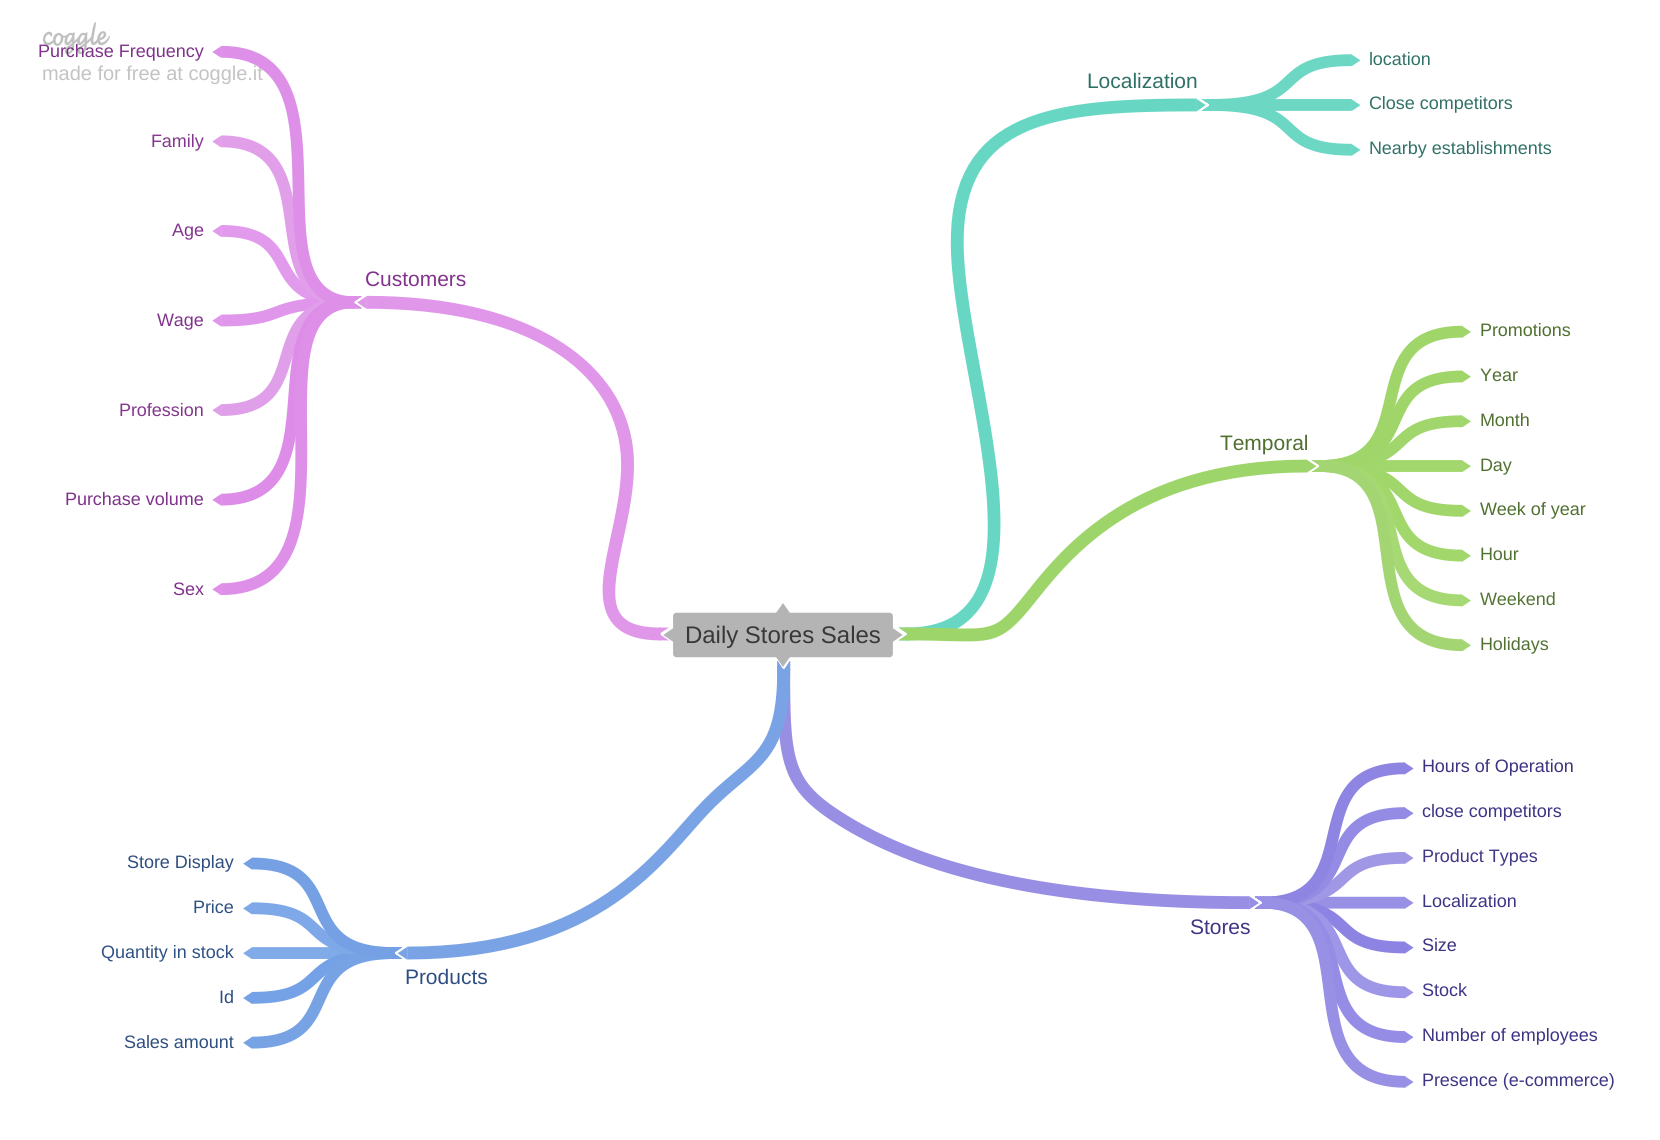

In [26]:
Image('Imagens/Mind_Maping_Daily_Stores_Sales_English_Version.png')

## 2.2 Hypothesis

In this section, we'll create some hypotheses about the topic to validate with an exploration of the data.

### 2.2.1 Hypothesis Related to Stores

**1.** Stores with more employees sell or should sell more.

**2.** Stores with more inventory sell or should sell more.

**3.** Larger stores should sell more.

**4.** Stores with a larger assortment should sell more. (Product Types)

**5.** Stores with closer competitors should sell less.

**6.** Stores with longer-term competitors should sell more.

### 2.2.2 Hypothesis Related to Products

**1.** Stores that invest more in marketing should sell more.

**2.** Stores that display more products in the window should sell more.

**3.** Stores that have lower prices on products should sell more.

**4.** Stores that have lower prices for longer on products should sell more (prolonged promotion).

**5.** Stores with more aggressive promotions (bigger discounts) should sell more.

**6.** Stores with promotions active for longer should sell more.

**7.** Stores with more promotion days should sell more.

**8.** Stores with more consecutive promotions should sell more.

### 2.2.3 Hypothesis Related to Time

**1.** Stores open during the Christmas holiday should sell more.

**2.** Stores should sell more over the years.

**3.** Stores should sell more in the second half of the year.

**4.** Stores should sell more after the 10th of each month.

**5.** Stores should sell less on weekends.

**6.** Stores should sell less during school holidays.

## 2.3 Final List of Hypothesis

This is the list of hypotheses that we are going to validate.

**1.** Stores with a larger assortment should sell more. (Product Types)

**2.** Stores with closer competitors should sell less.

**3.** Stores with longer-term competitors should sell more.

**4.** Stores with promotions active for longer should sell more.

**5.** Stores with more promotion days should sell more.

**6.** Stores with more consecutive promotions should sell more.

**7.** Stores open during the Christmas holiday should sell more.

**8.** Stores should sell more over the years.

**9.** Stores should sell more in the second half of the year.

**10.** Stores should sell more after the 10th of each month.

**11.** Stores should sell less on weekends.

**12.** Stores should sell less during school holidays.

## 2.4 Feature Engineering

This is the process to extract features from raw data. Here we'll extract some important features to the project.

In [27]:
# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of Year
df2['week_of_year'] = df2['date'].dt.weekofyear

# Year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# Competition Since  
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'], month = x['competition_open_since_month'] , day=1), axis = 1)

df2['competition_time_month'] = ((df2['date'] - df2['competition_since'] )/ 30).apply(lambda x: x.days).astype(int)

# Promo Since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)


# Assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# State Holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [28]:
# Seeing feature engineering
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtering of Variables

In [29]:
# Make a copy of the data
df3 = df2.copy()

# See some rows
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Filtering of Rows

In [30]:
# Filtering rows that represent important data to the project. In this case are the open stores and stores that make sales.
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.1 Filtering of Columns

In [31]:
# Droping columns that are will not used

cols_drop = ['customers','open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [32]:
# See final list of columns
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Exploratory Data Analysis

In this section we will explore the data and validate the hypotheses created in section 2.0

In [33]:
# Make a copy of the dataset
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

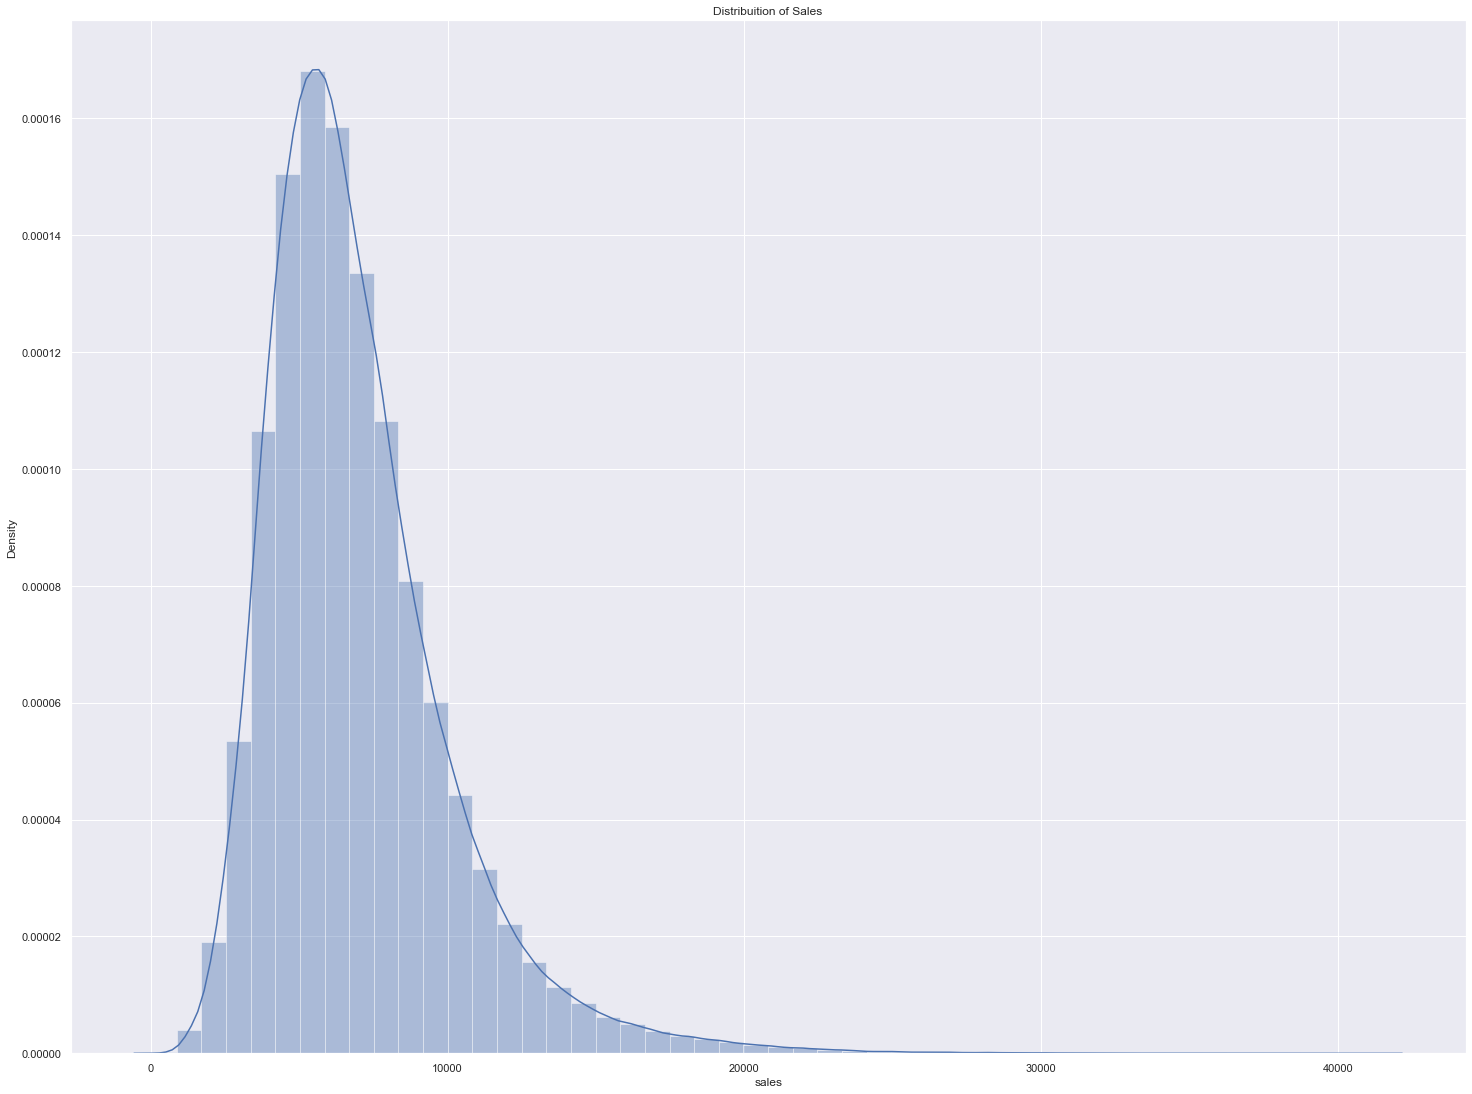

In [34]:
# see the distribuition of sales, to make more clear how the data are.
sns.distplot(df4['sales']).set_title('Distribuition of Sales');

### 4.1.2 Numerical Variable

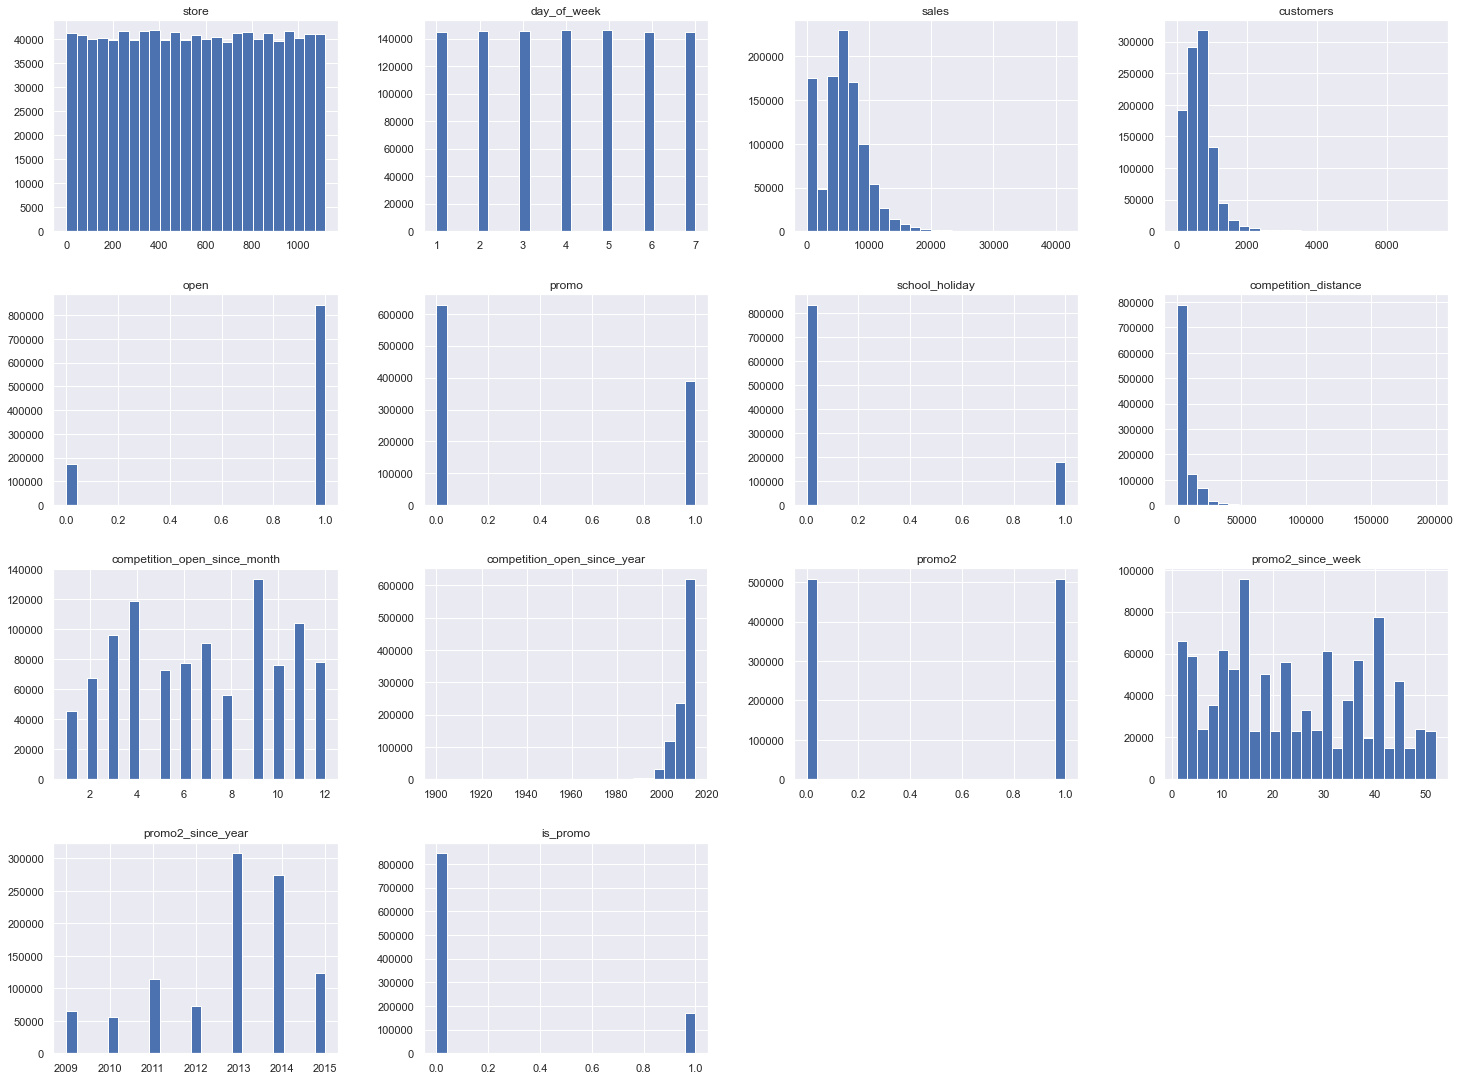

In [35]:
num_attributes.hist(bins= 25);

### 4.1.3 Categorical Variable

In [36]:
# Drop duplicate values of assortment
df4['assortment'].drop_duplicates()

0         basic
3      extended
258       extra
Name: assortment, dtype: object

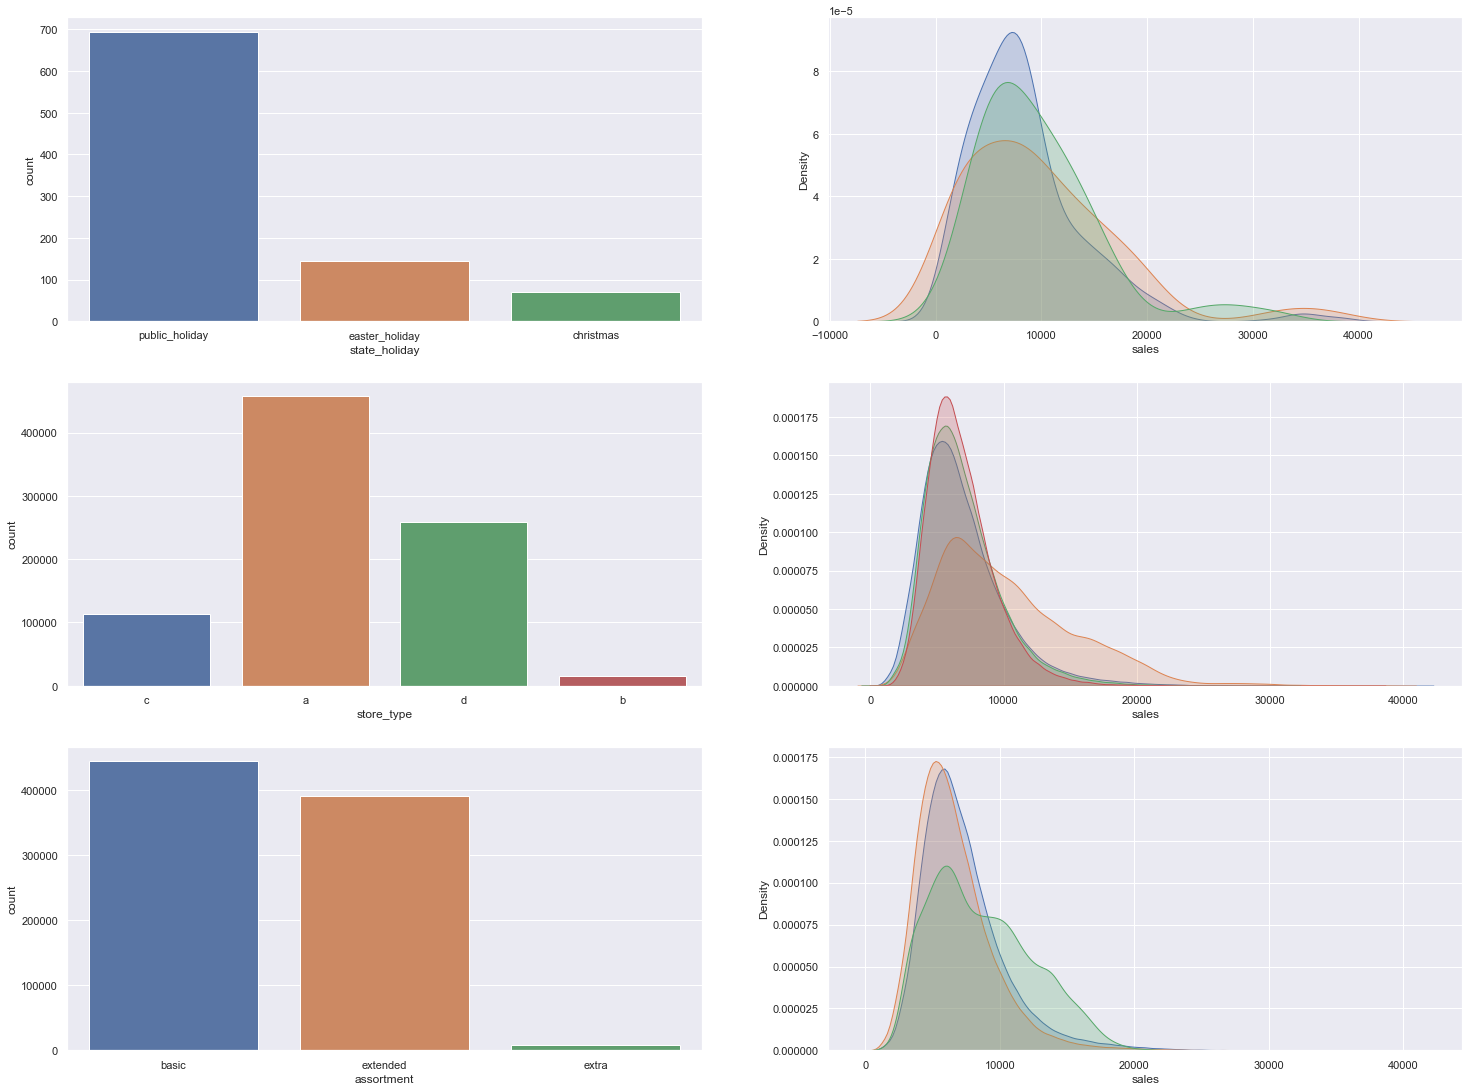

In [37]:
# State Holiday Analysis

plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True);
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True);
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True);


# Story Type Analysis

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True);
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True);

# Analysis of Assortment

plt.subplot(3,2,5)
sns.countplot(df4['assortment']);

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True);
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True);
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True);

## 4.2 Bivariate Analysis
In this section we will use bivariate analysis to validate the hypotheses.

### **H1.** Stores with a larger assortment should sell more. (Product Types)

Answer: False! Stores with a larger assortment no longer sell.
In terms of the variable, it still becomes important by the model, since basic and extended have very similar behavior and extra a different behavior (seasonality).

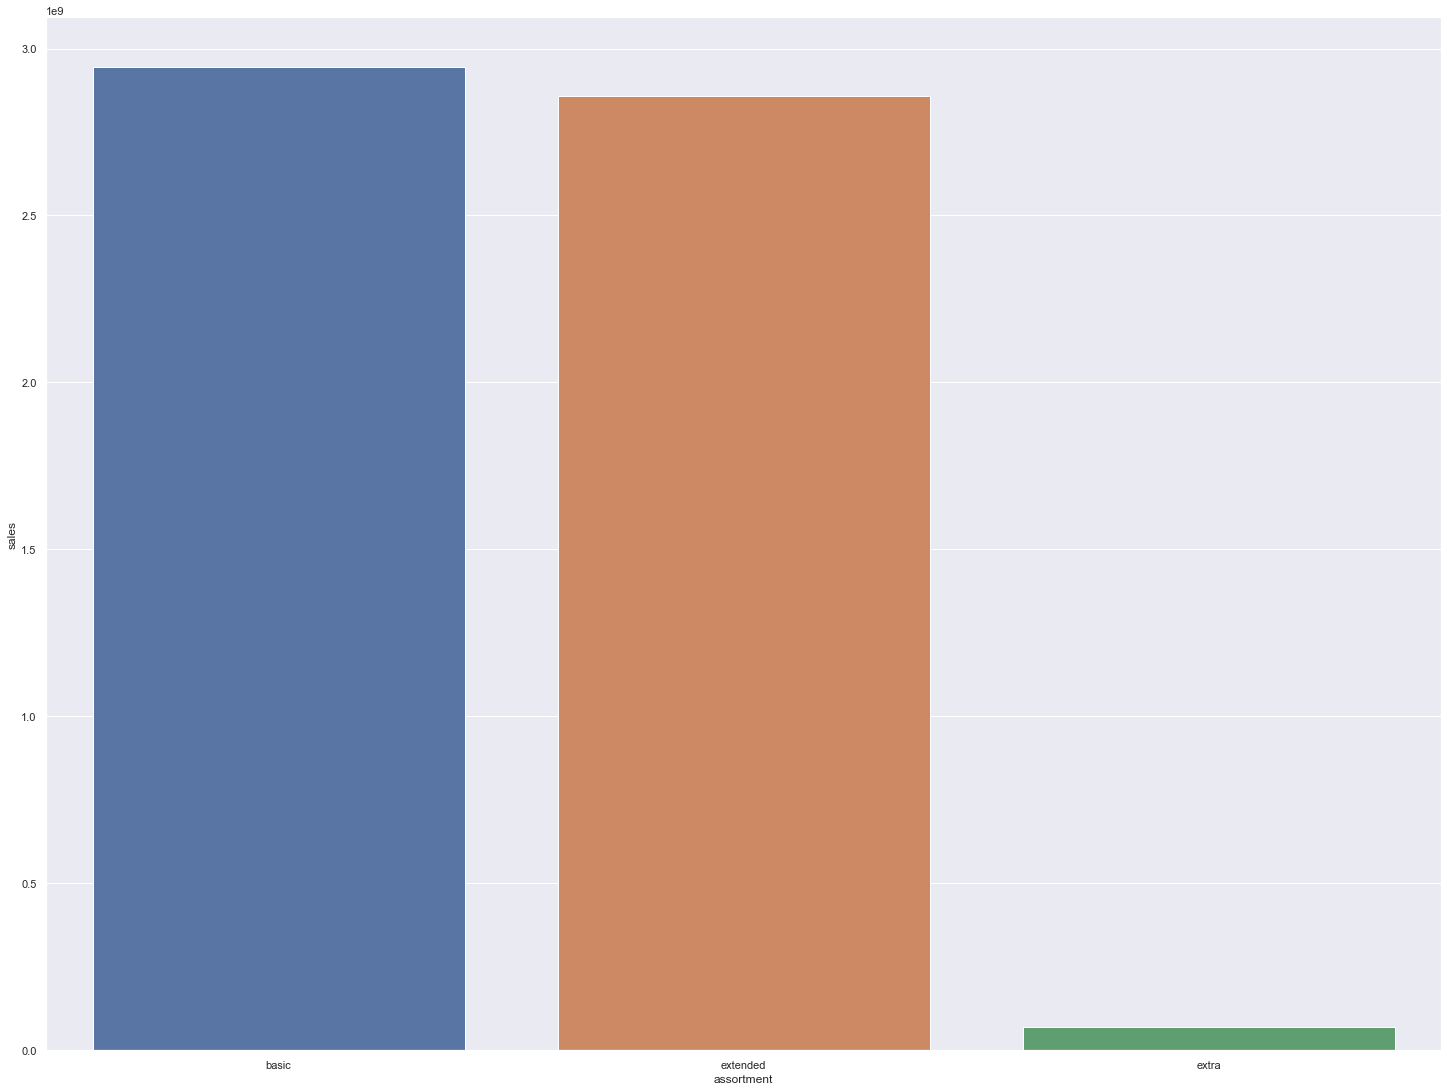

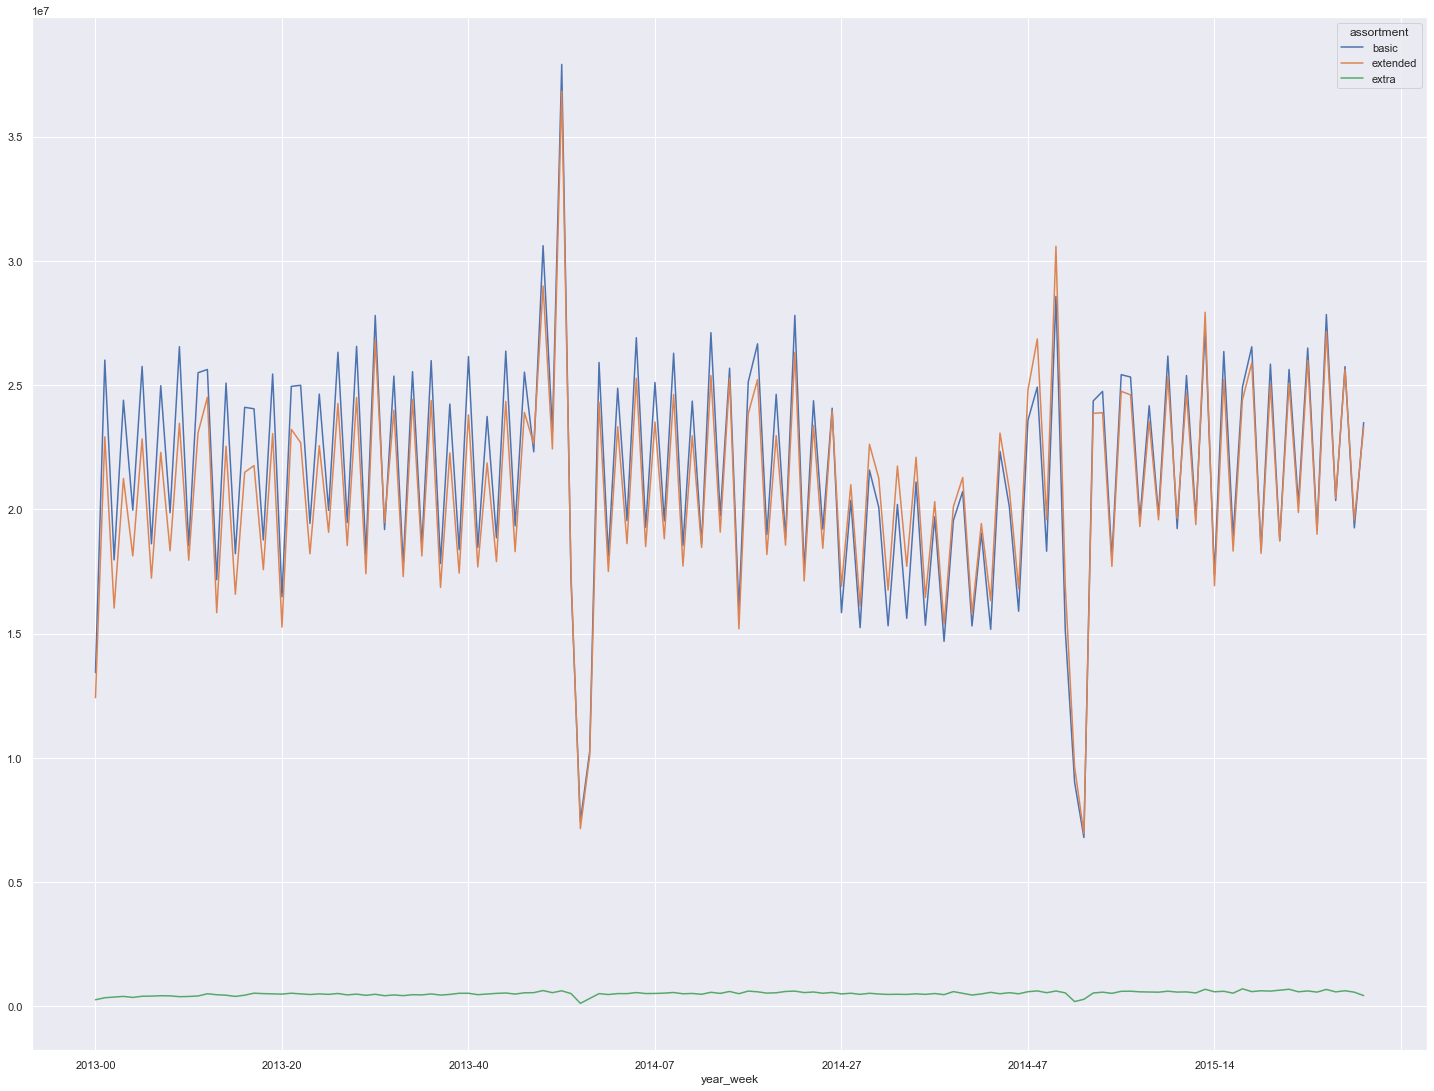

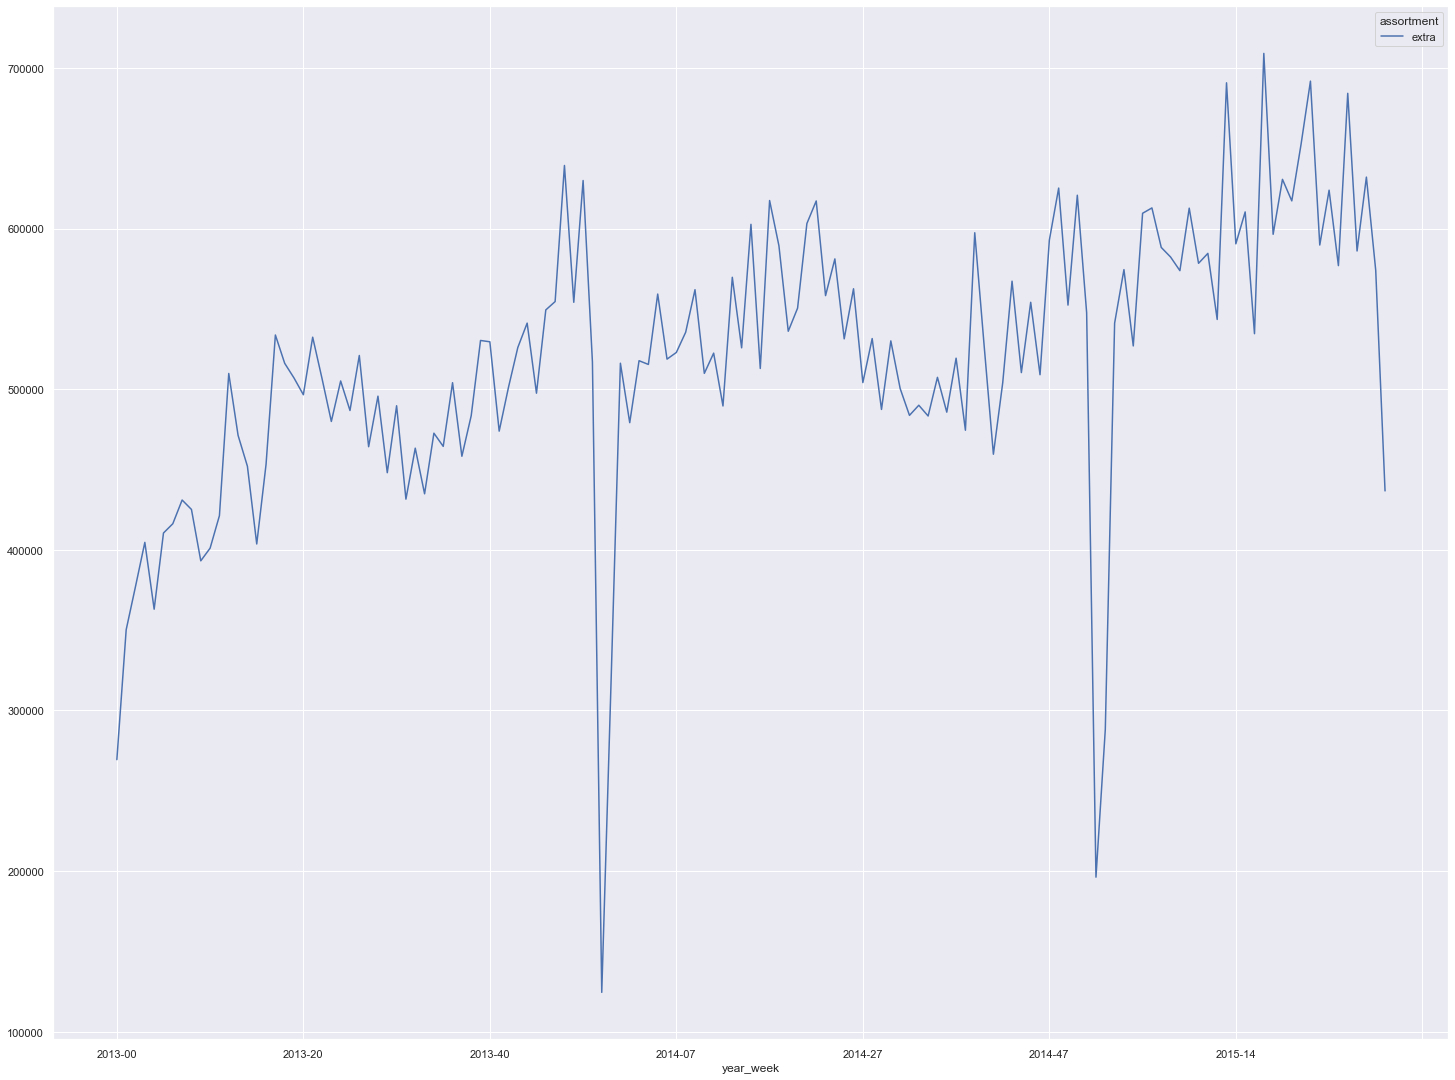

In [38]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x = 'assortment', y = 'sales', data = aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index ='year_week', columns = 'assortment', values ='sales').plot();

# Função pivot transforma os valores de assortment em colunas, deixando como valor único o year week.

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index ='year_week', columns = 'assortment', values ='sales').plot();

### **H2.** Stores with closer competitors should sell less.
Answer: False! Stores with closest competitors sell more.

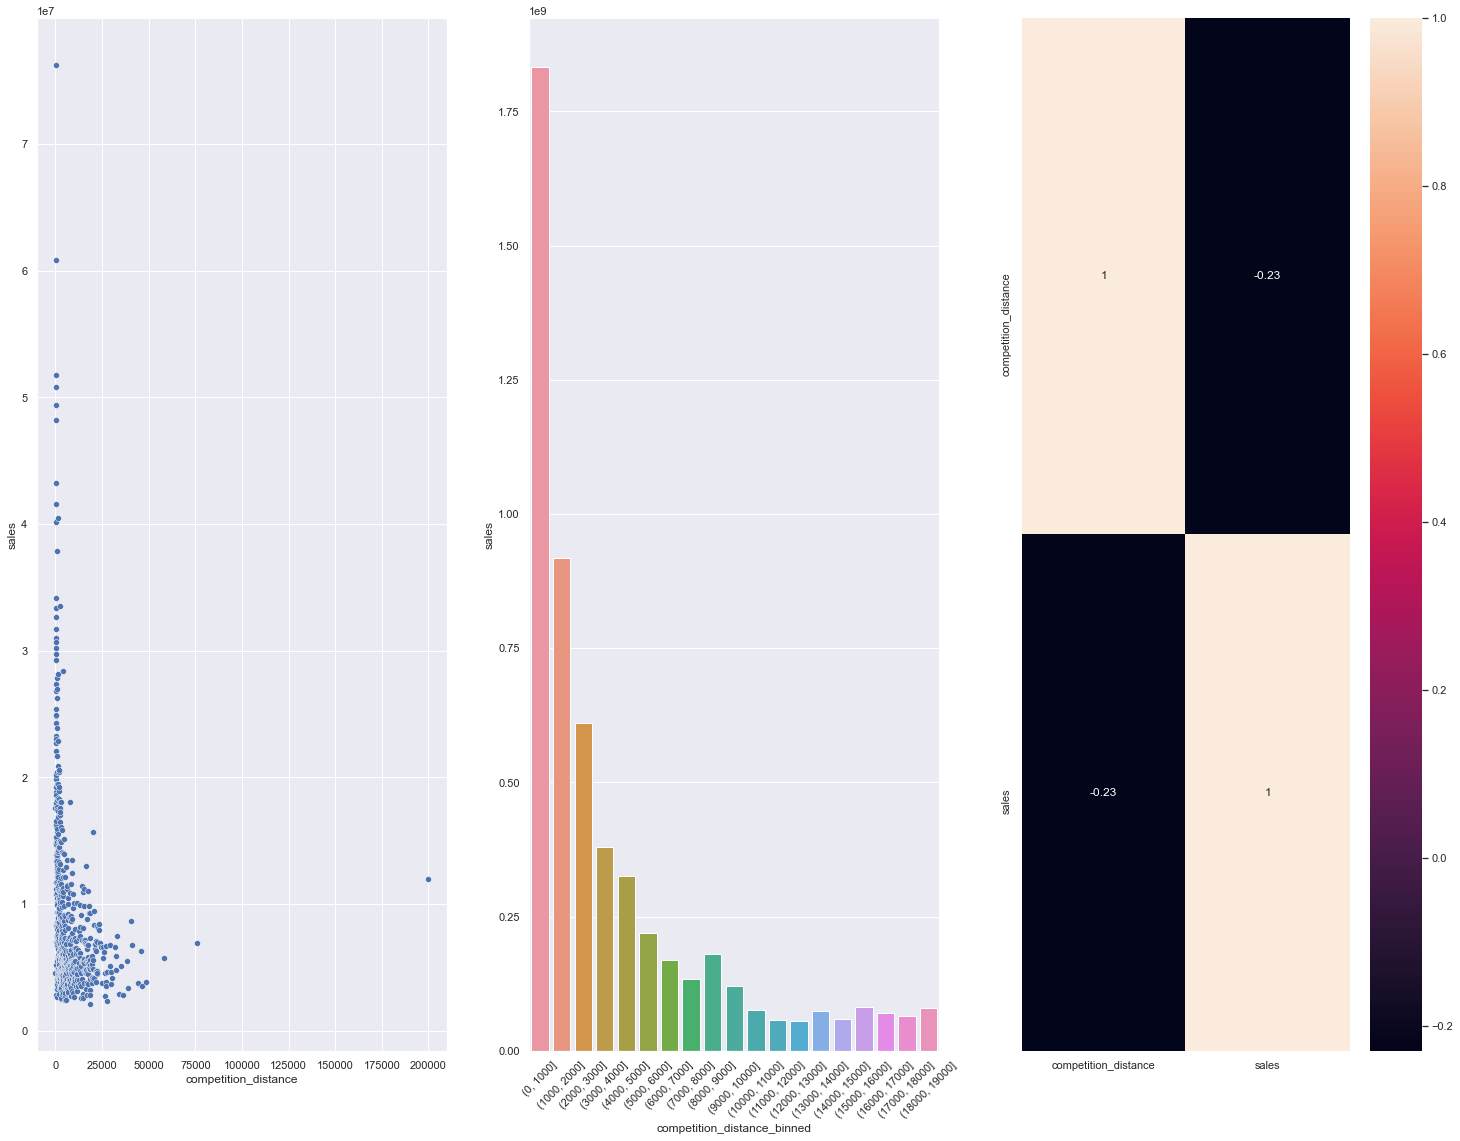

In [39]:
aux1 = df4[['competition_distance','sales',]].groupby('competition_distance').sum().reset_index()


plt.subplot(1, 3, 1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data = aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned','sales',]].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x = 'competition_distance_binned', y = 'sales', data = aux2);
plt.xticks(rotation = 45)

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

### **H3.** Stores with longer-term competitors should sell more.
Answer: False! Stores with competitors for longer sell less

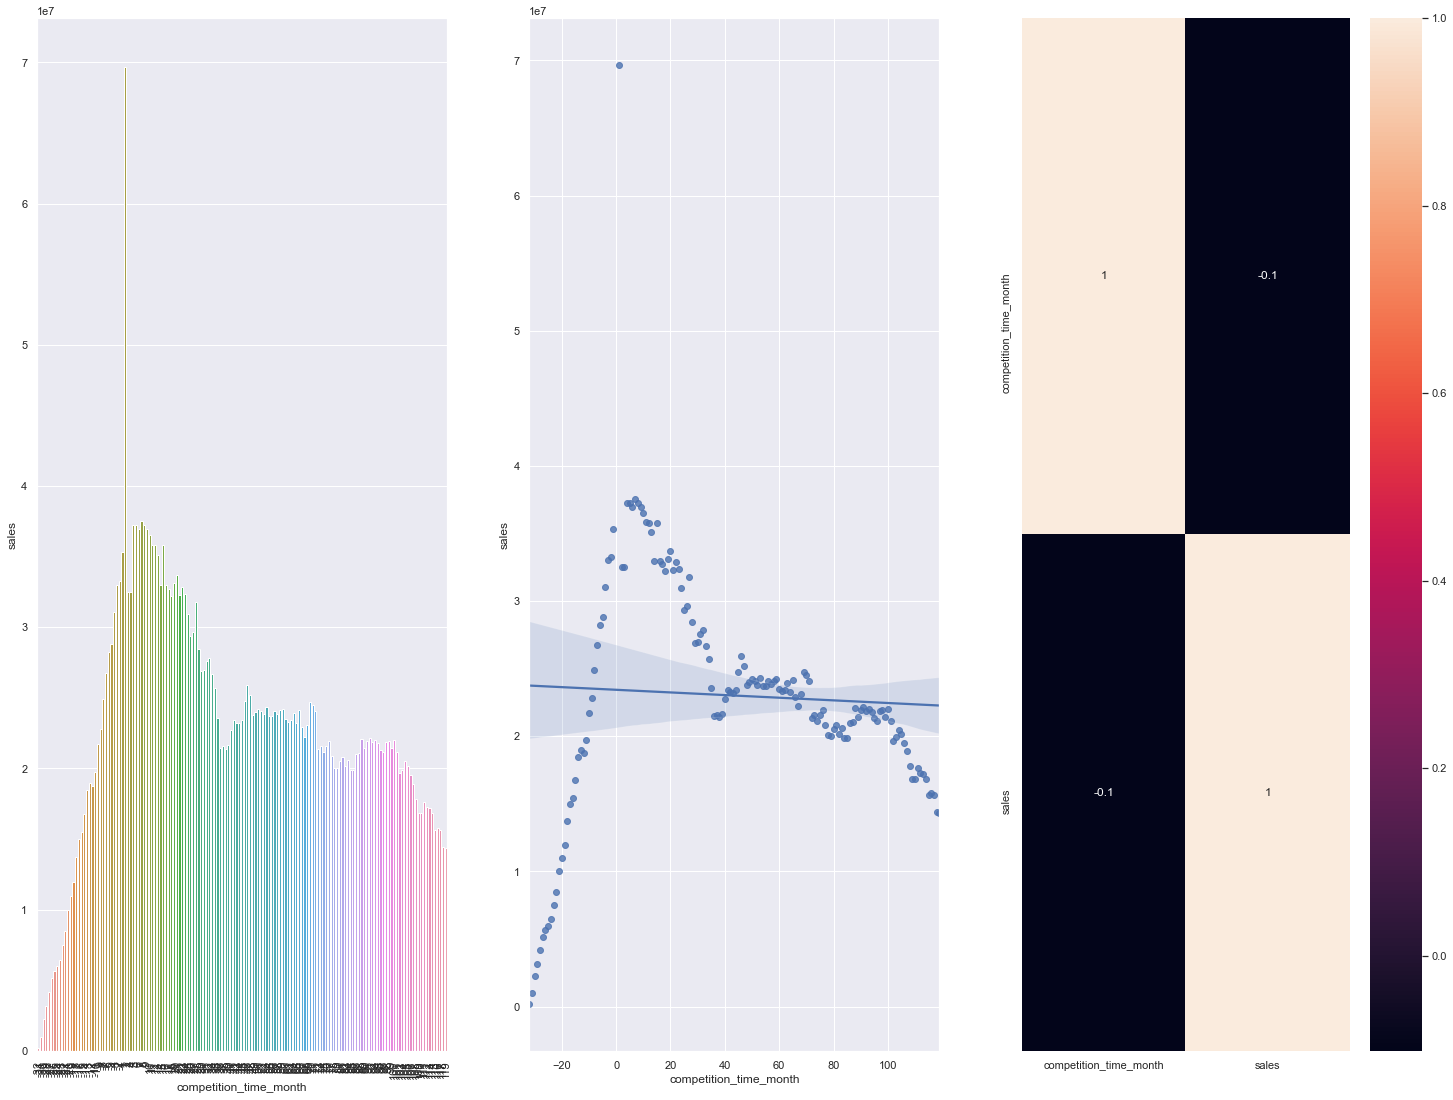

In [40]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month',  y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x = 'competition_time_month',  y = 'sales', data = aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

### **H4.** Stores with promotions active for longer should sell more.
Answer: False! We can see that there are regular sales and after a period sales drop.
Model relevance: There is data behavior, but it is weak. It is necessary to assess whether it is important to the model.

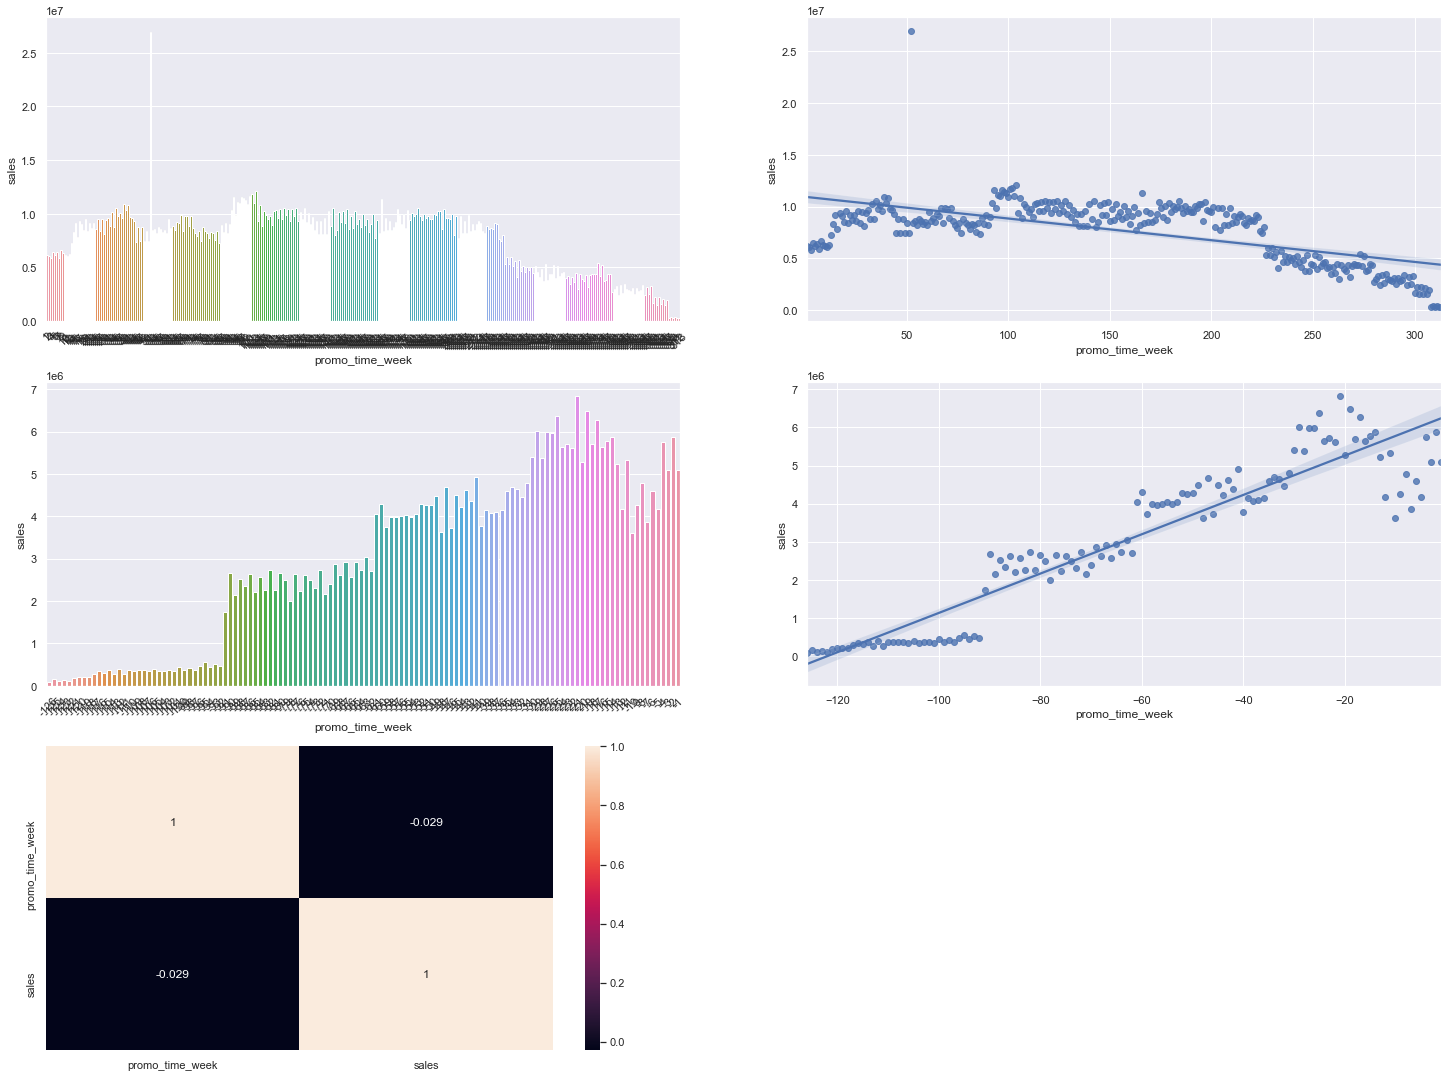

In [41]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()



plt.subplot(3,2,1)
aux2 = aux1[aux1['promo_time_week'] > 0 ] # Maior que 0 promo extendida
sns.barplot(x ='promo_time_week', y='sales' , data = aux2);
plt.xticks(rotation = 45);

plt.subplot(3,2,2)
sns.regplot(x ='promo_time_week', y='sales' , data = aux2);

plt.subplot(3,2,3)
aux3 = aux1[aux1['promo_time_week'] < 0 ] # Menor que 0 promo regular
sns.barplot(x ='promo_time_week', y='sales' , data = aux3);
plt.xticks(rotation = 45);

plt.subplot(3,2,4)
sns.regplot(x ='promo_time_week', y='sales' , data = aux3);

plt.subplot(3,2,5)
sns.heatmap(aux1.corr(method = 'pearson'), annot=True);

### <s>**H5.** Stores with more promotion days should sell more.</s>
Answer: Taking into account that stores with active promotions for a longer time do not sell anymore (top hypothesis), this hypothesis ends up being false as well. In order to actually validate, it is necessary to derive the days of promotions and group them by stores.

### **H6.** Stores with more consecutive promotions should sell more
Answer: False! Stores with consecutive promotions no longer sell, however the variable is important for the model.

In [42]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


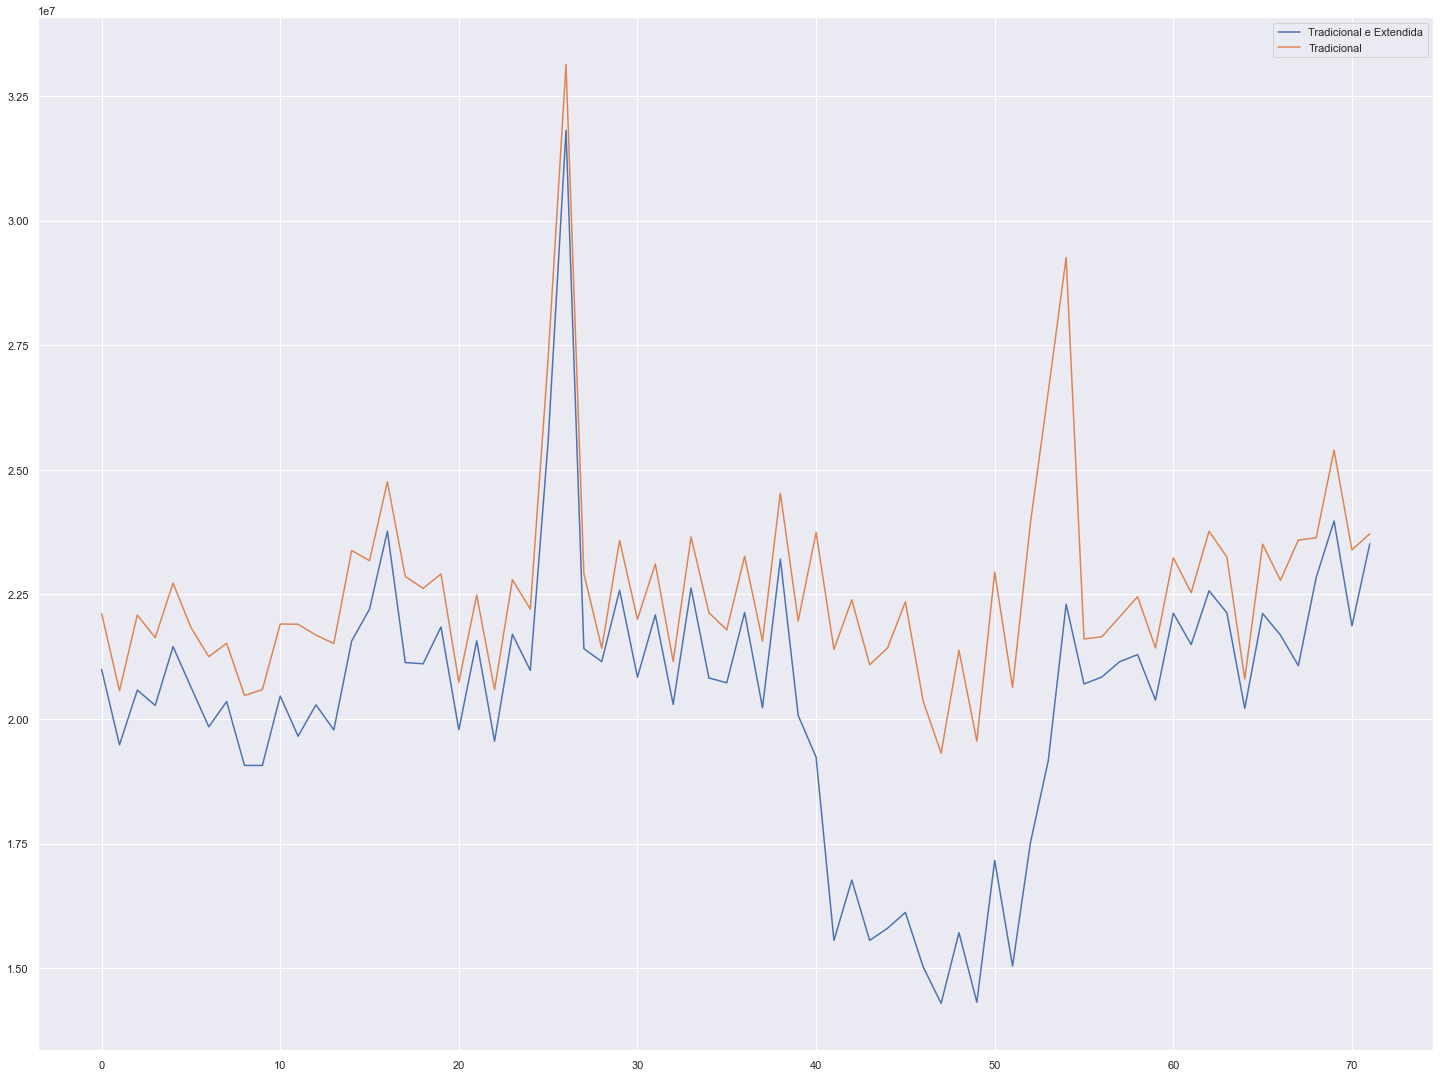

In [43]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels = ['Tradicional e Extendida', 'Tradicional'])

### **H7.** Stores open during the Christmas holiday should sell more.

Answer: False! There are no more sales at Christmas than other holidays

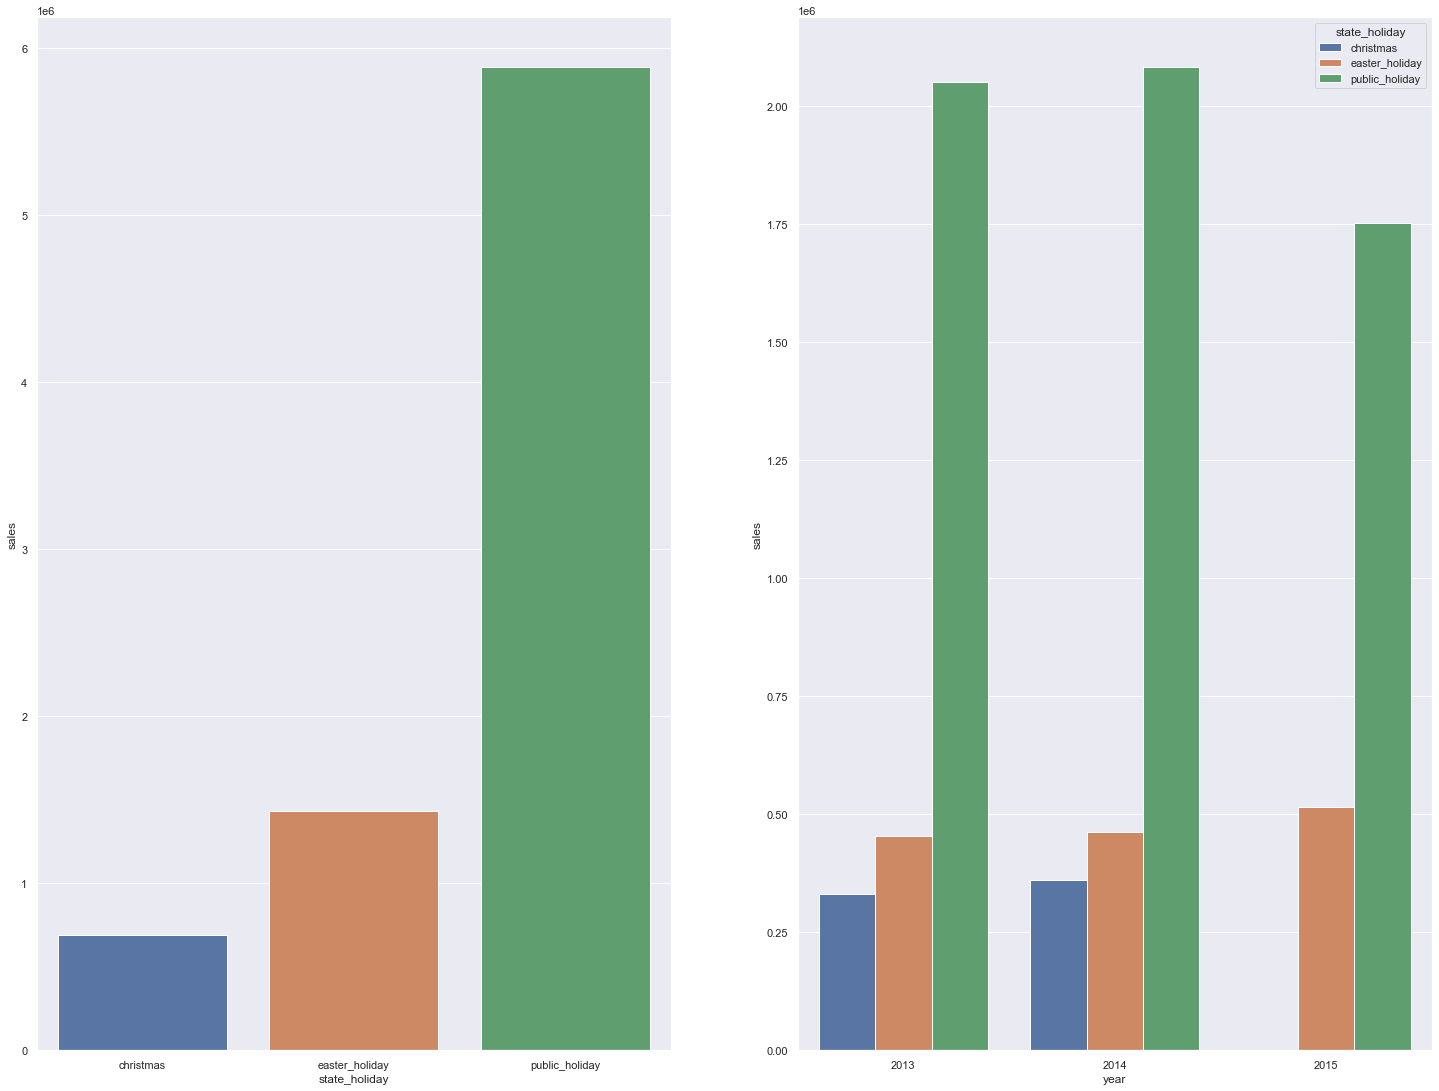

In [44]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1, 2, 1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data = aux1);

plt.subplot(1, 2, 2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x= 'year', y ='sales', hue = 'state_holiday', data = aux2);

### **H8.** Stores should sell more over the years.

Answer: False! Stores sell less over the years.

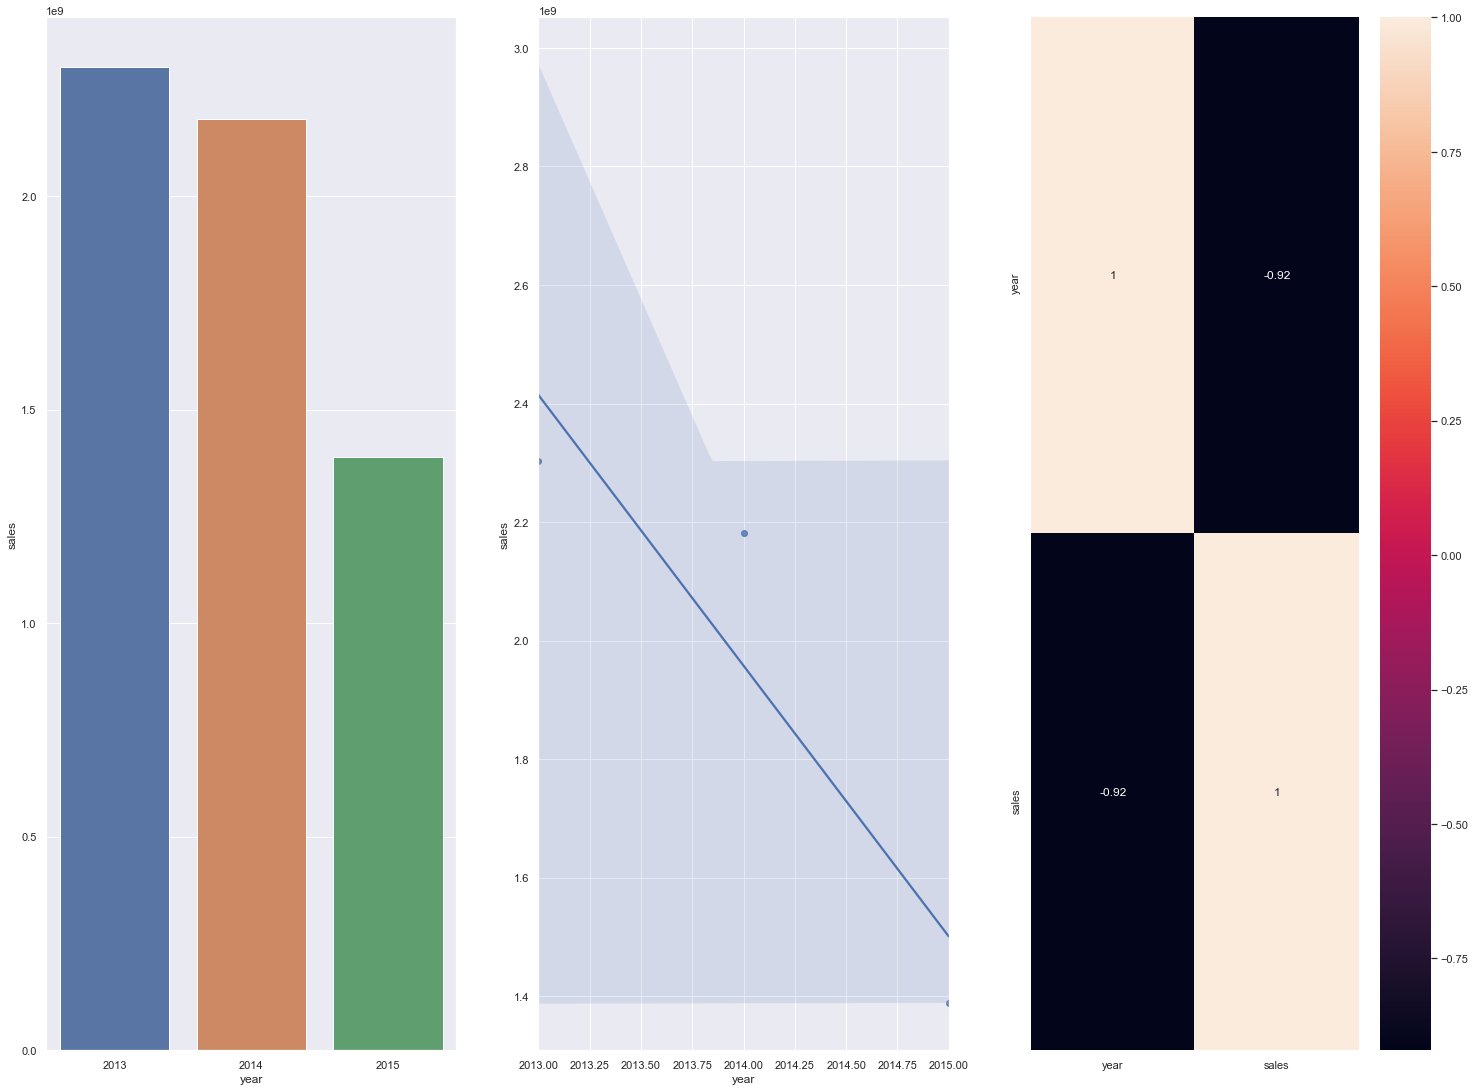

In [45]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot= True);

### **H9.** Stores should sell more in the second half of the year.

Answer: False! Stores sell less from the second half, with a drop between months 7 and 9.

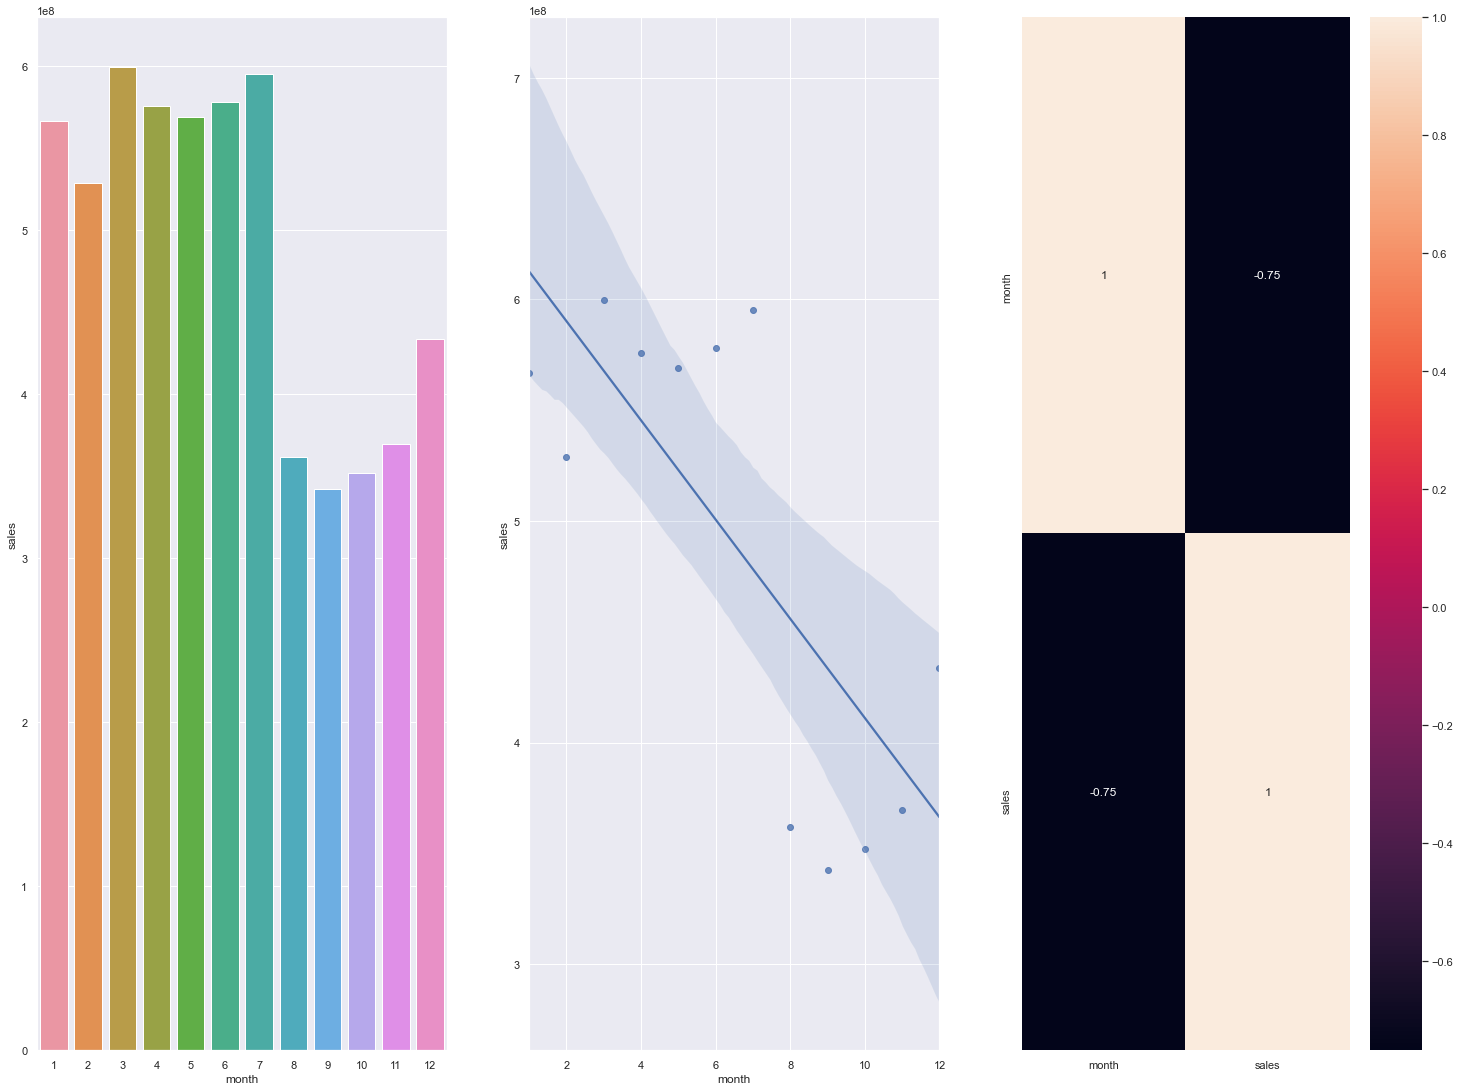

In [46]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot= True);

### **H10.** Stores should sell more after the 10th of each month.

Answer: True! Stores sell more after the 10th of each month.

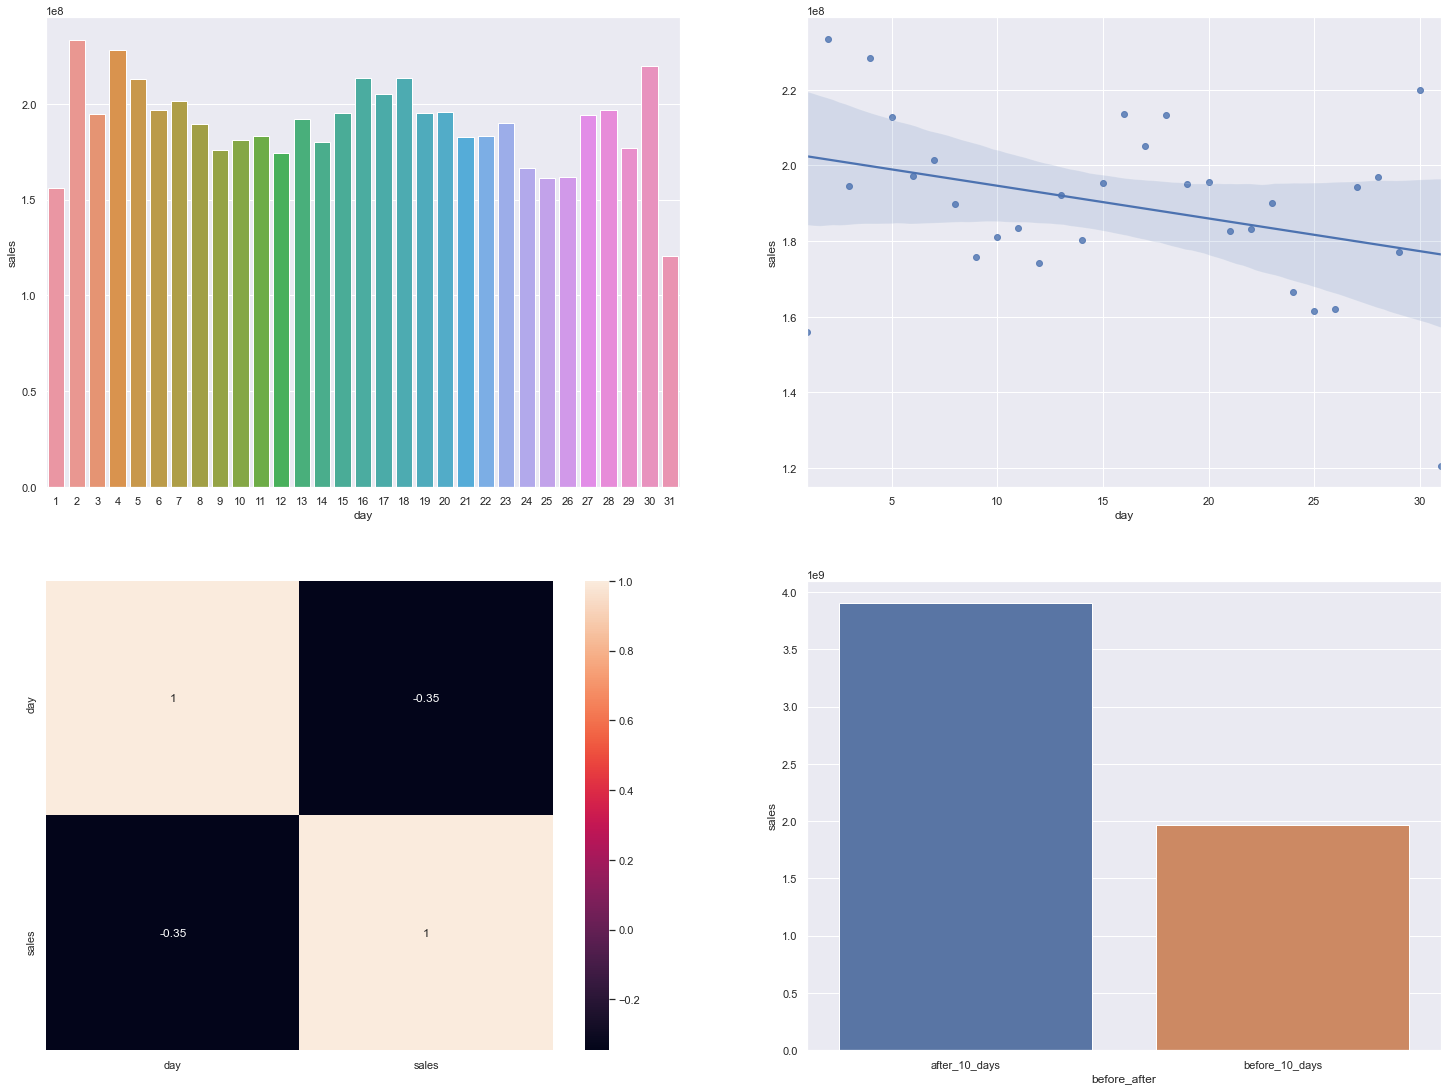

In [47]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

plt.subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot= True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2, 2, 4)
sns.barplot(x = 'before_after', y= 'sales', data=aux2);

### **H11.** Stores should sell less on weekends.

Answer: True! Sales drop more on weekends.

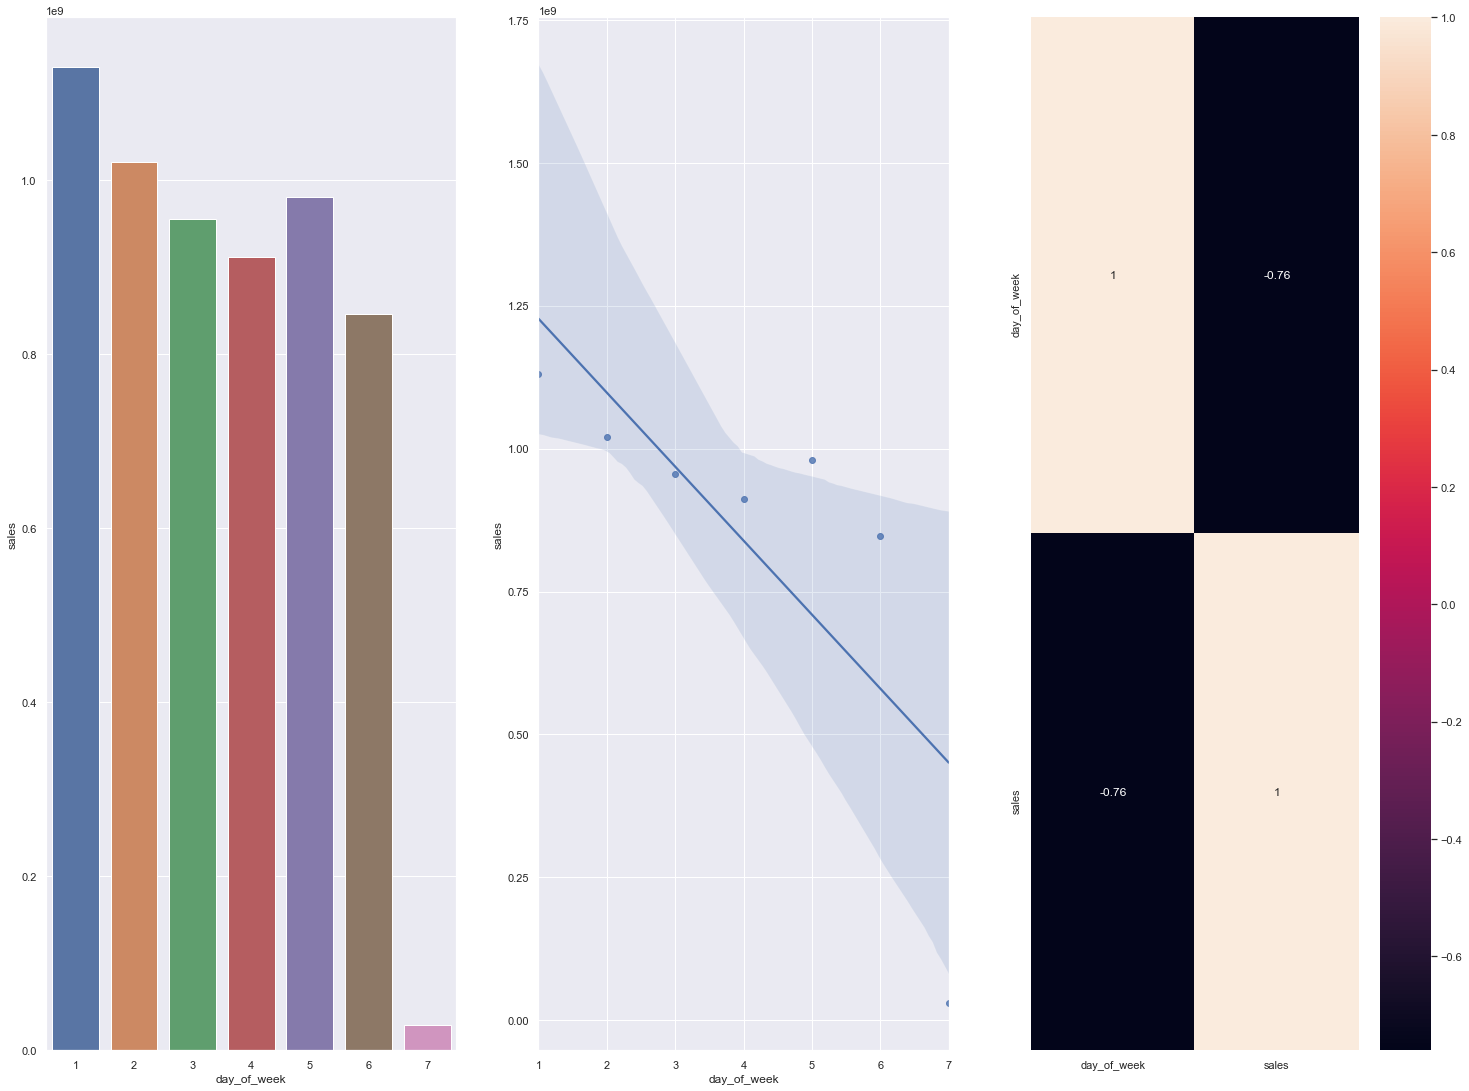

In [48]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot= True);

### **H12.** Stores should sell less during school holidays.

Answer: True! However, there are periods that during the holiday period there are more sales, such as months 7 and 8. These months can be explained by school holidays.

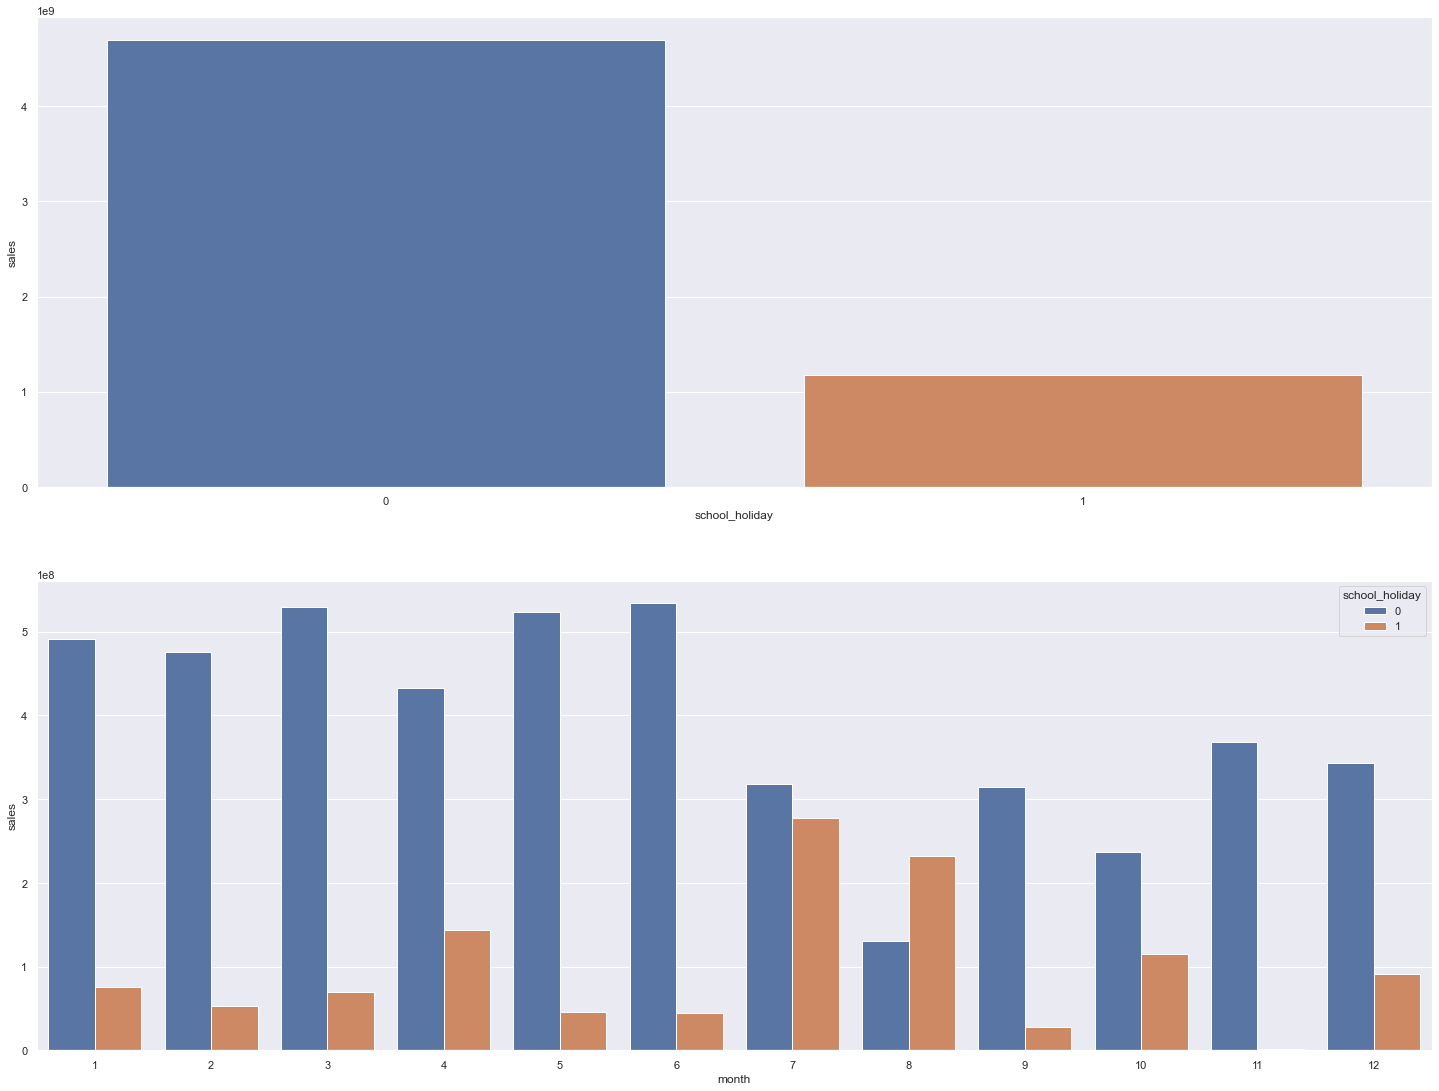

In [49]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales',hue='school_holiday', data = aux2);

## 4.3 Multivariate analysis
In this section we will use Multivariate analysis to validate the hypotheses.

### 4.3.1 Numerical Attributes

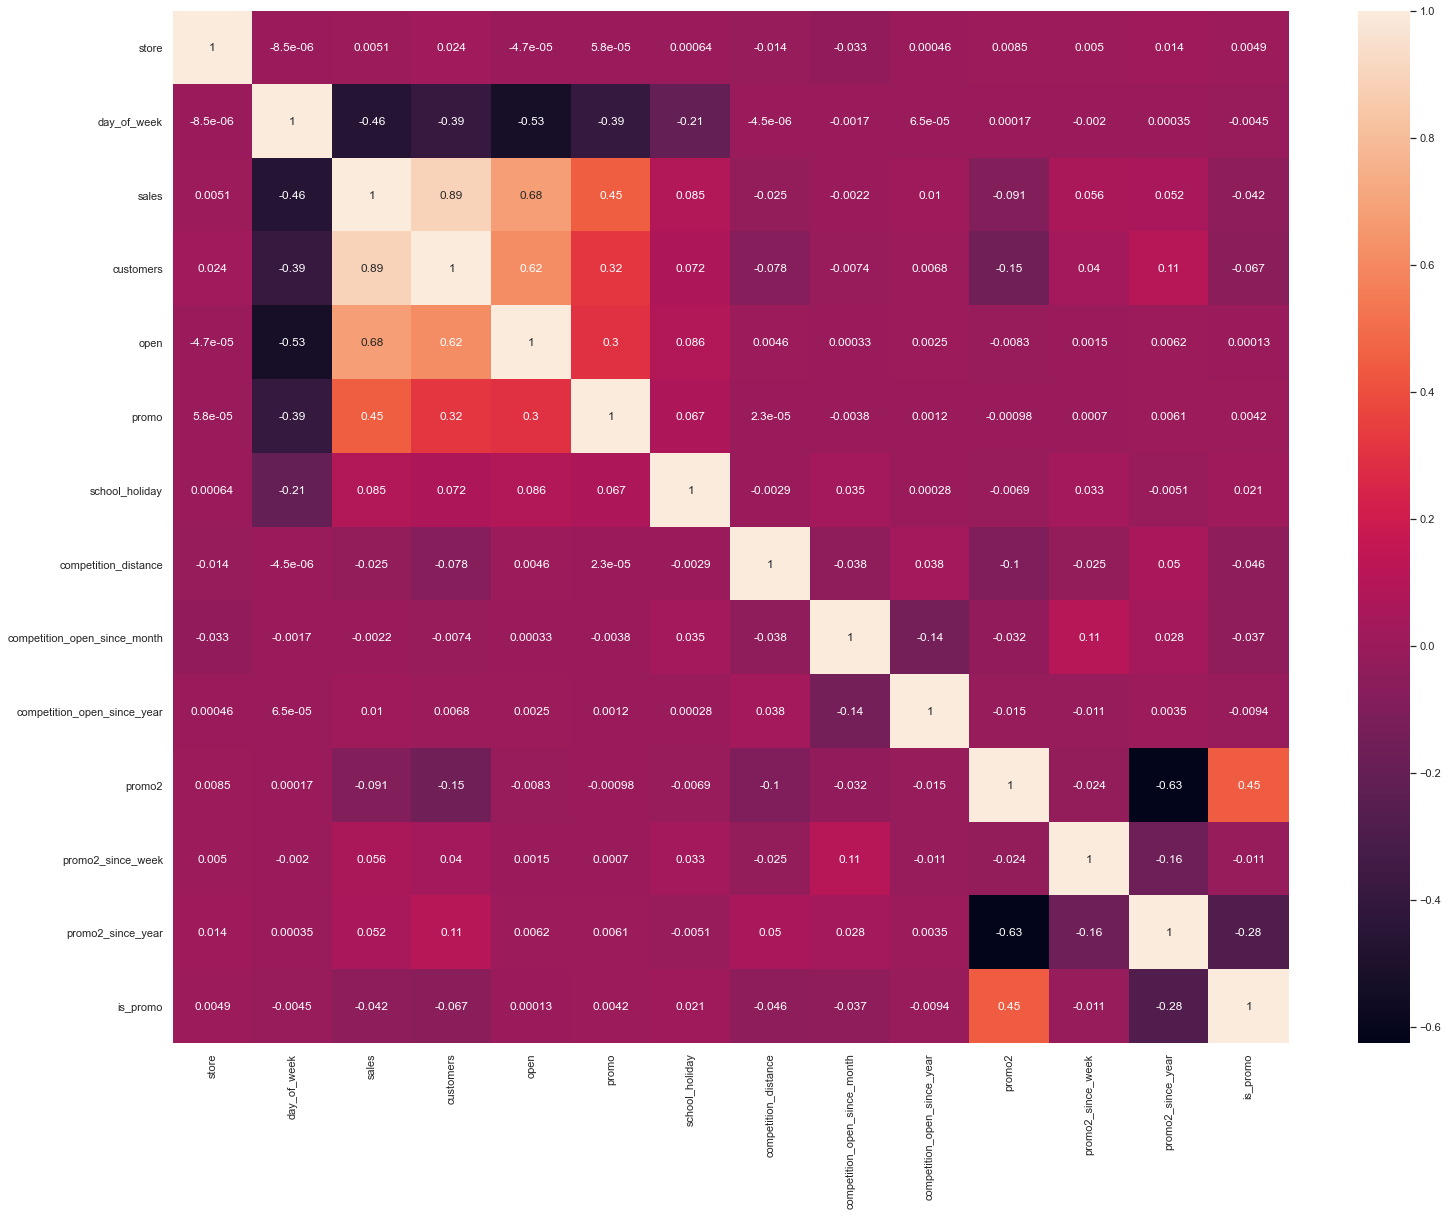

In [50]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

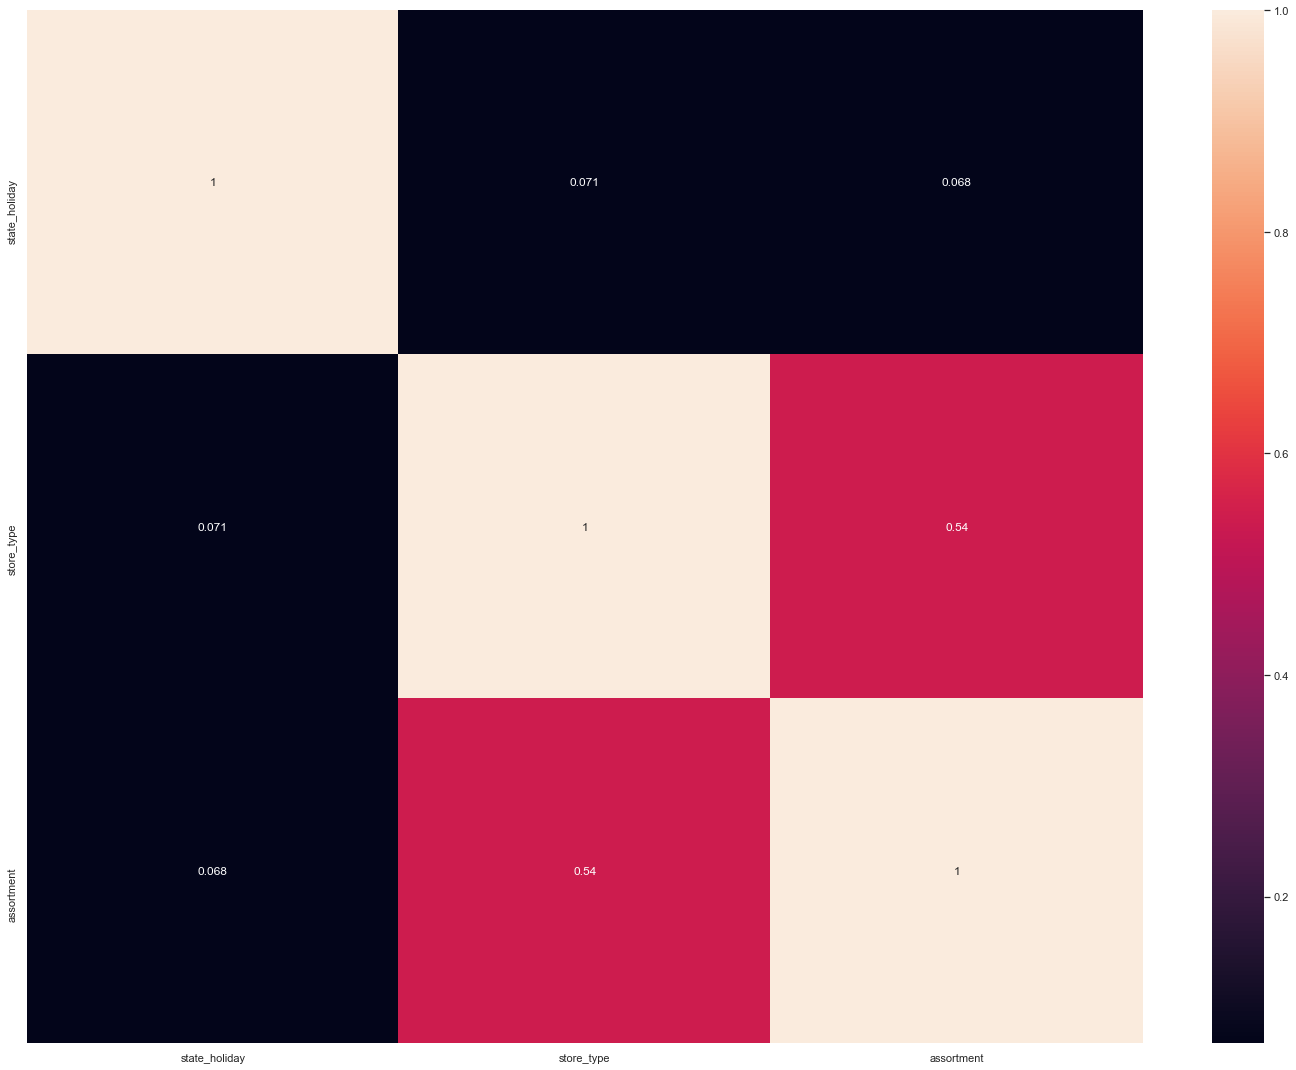

In [51]:
a = df4.select_dtypes(include= 'object')
a.head()

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2= cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d= pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9]})

d = d.set_index(d.columns)
d

sns. heatmap(d, annot=True);

# 5.0 Data Preparation

In [52]:
# Make a copy
df5 = df4.copy()

## 5.1 Normalization

To normalize the variables, just check the variables that have normal distribution in the univariate analysis. If there are no variables with this type of distribution, this procedure is not performed. In this case, we don't need to do this procedure.

## 5.2 Rescaling

In [53]:
# Selected data by type for rescaling
a = df5.select_dtypes(include = ['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,promo2,is_promo,year,month,day,week_of_year
0,1,5,5263,1,1,1270.0,0,0,2015,7,31,31
1,2,5,6064,1,1,570.0,1,1,2015,7,31,31
2,3,5,8314,1,1,14130.0,1,1,2015,7,31,31
3,4,5,13995,1,1,620.0,0,0,2015,7,31,31
4,5,5,4822,1,1,29910.0,0,0,2015,7,31,31


**Variables that the Rescaling will apply**

Competition Distance: Robust Scaler

Year: Min Max Scaler

Competition time month: Robust Scaler

Time week promo: Min Max Scaler

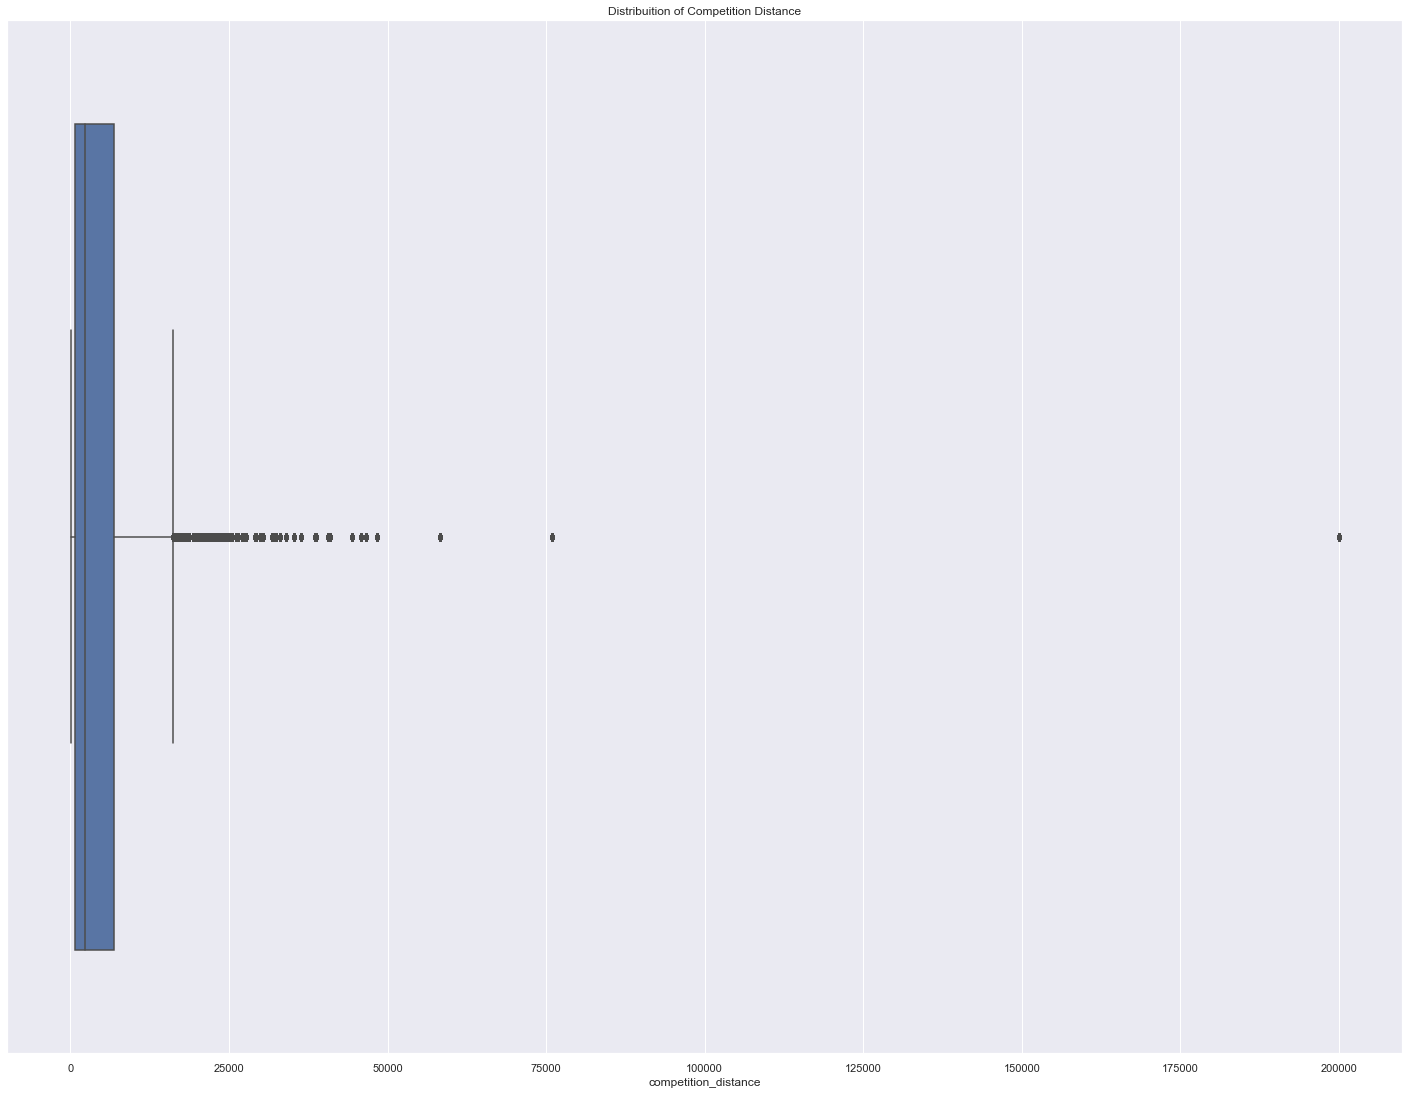

In [54]:
# Creating boxplot to check if the Competition Distance variable has outlier to define the rescaling.
sns.boxplot(df5['competition_distance']).set_title('Distribuition of Competition Distance');

In [55]:
# Robust Scaler in competition distance
rs = RobustScaler()
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# Saving enconding to deploy in Model of Machine Learning
pickle.dump(rs, open('C:/Users/MATESANTOS/Documents/Z/0_Estudos/Projetos/Rossmann-Store-Sales/Modelo/parameter/competition_distance_scaler.pkl', 'wb'))

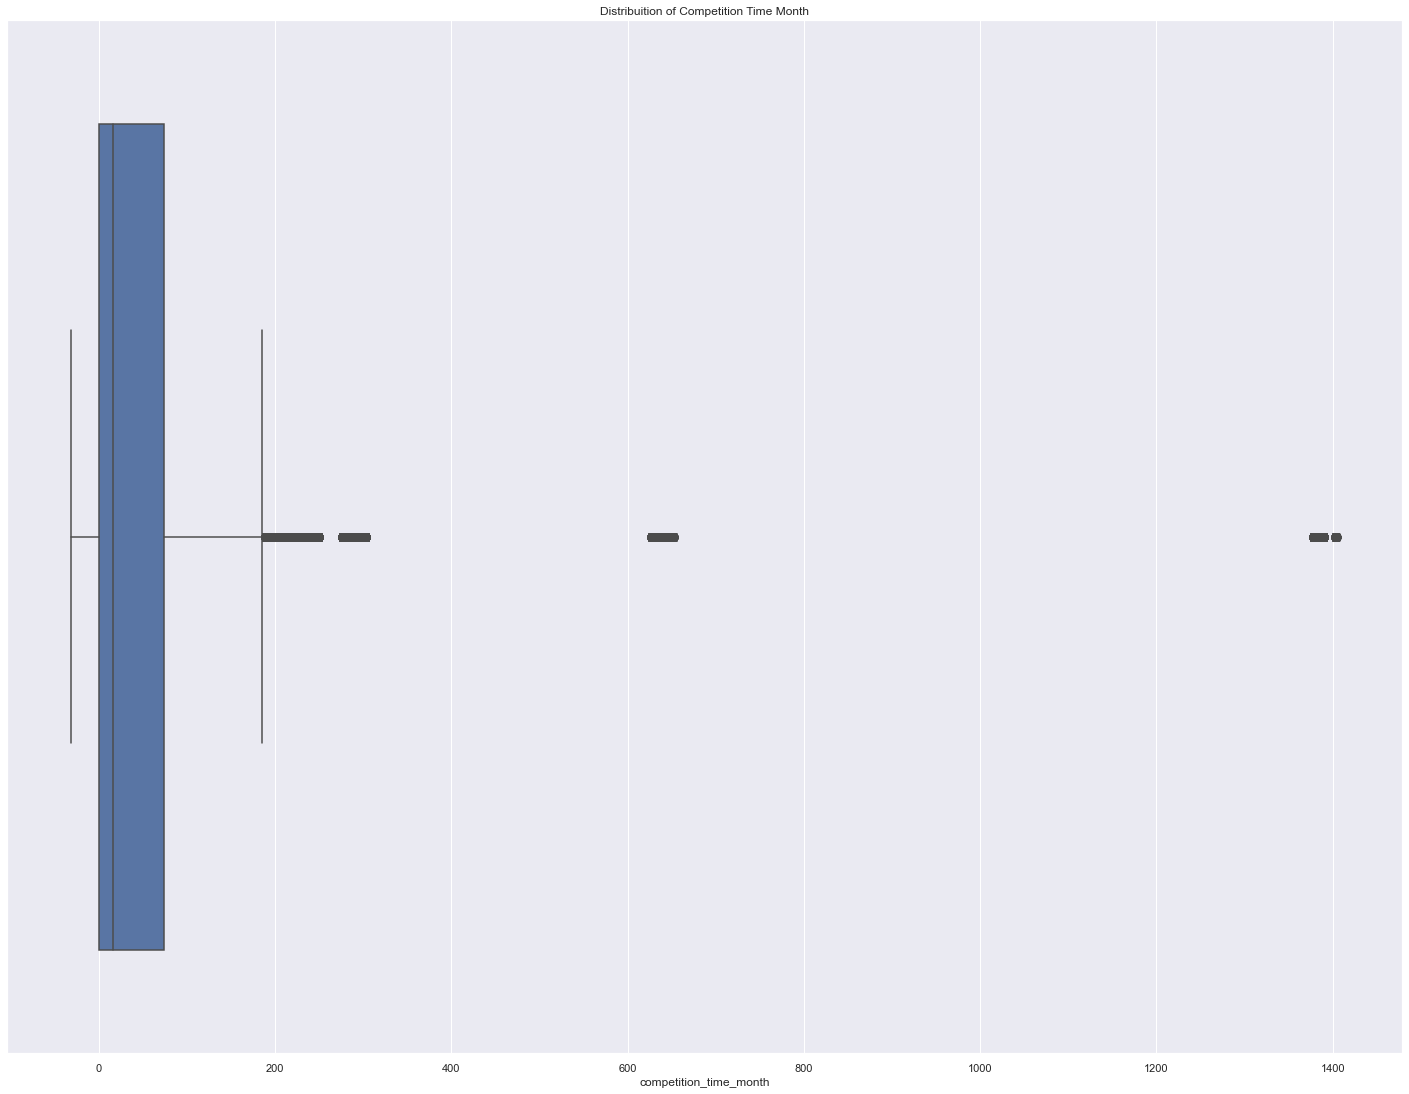

In [56]:
# Creating boxplot in Competition time month column to set the scaler
sns.boxplot(df5['competition_time_month']).set_title('Distribuition of Competition Time Month');

In [57]:
# Robust Scaler in Competition time month
rs = RobustScaler()
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# Saving enconding to deploy
pickle.dump(rs, open('C:/Users/MATESANTOS/Documents/Z/0_Estudos/Projetos/Rossmann-Store-Sales/Modelo/parameter/competition_time_month_scaler.pkl', 'wb'))

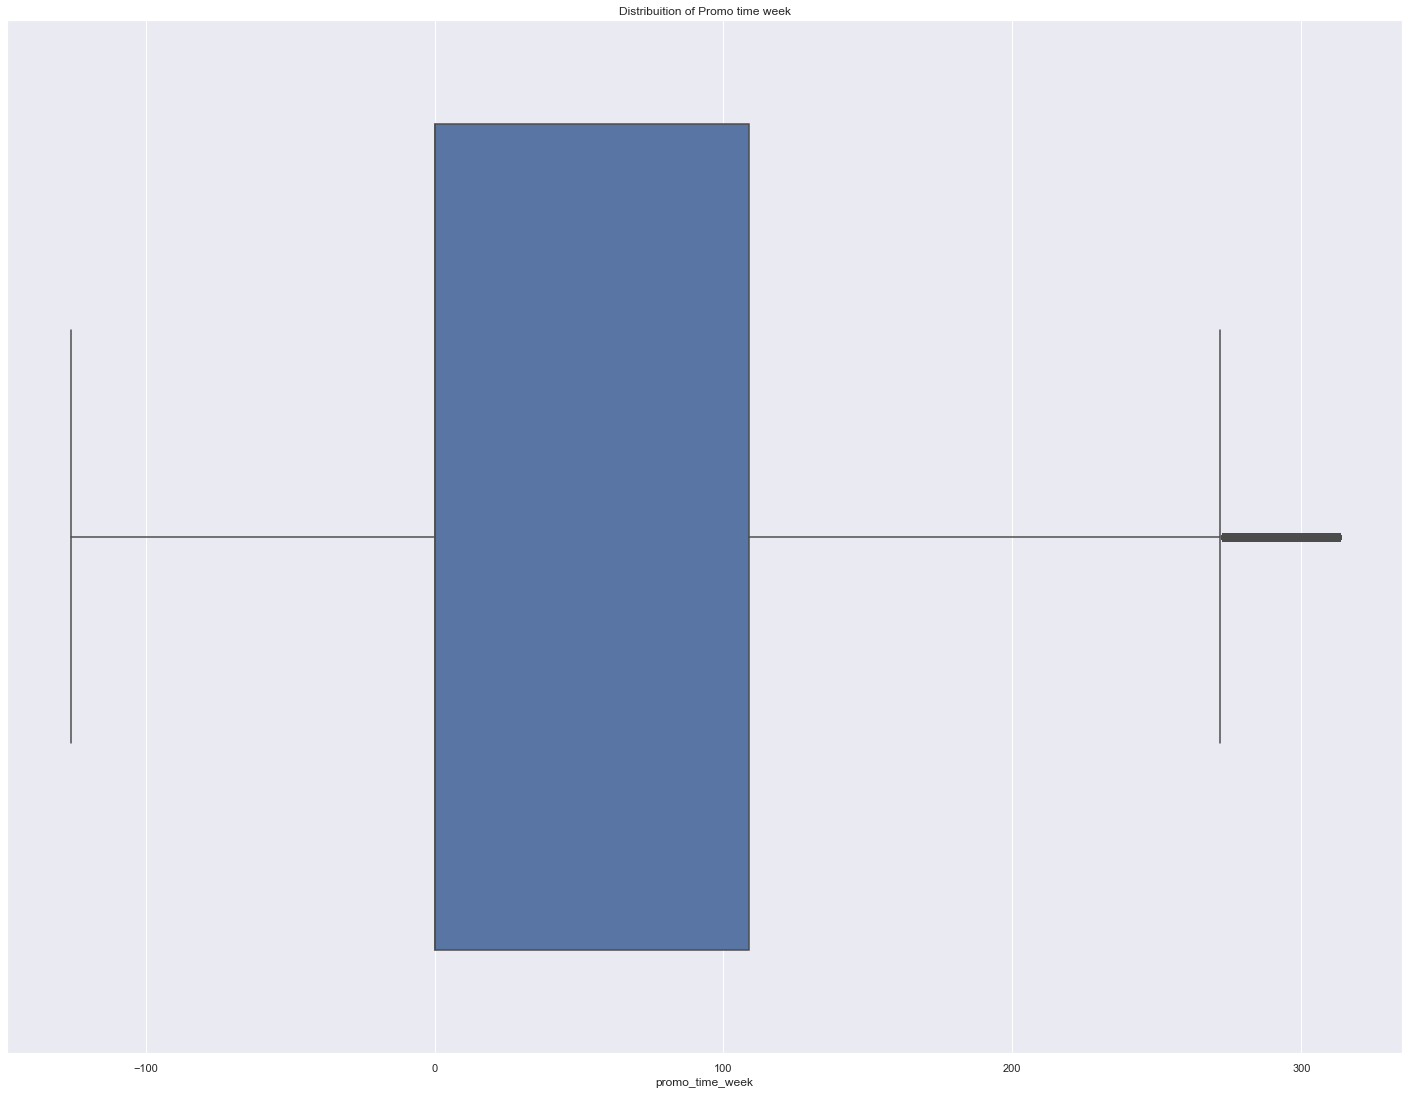

In [58]:
# Creating boxplot in Promo time week column to set scaler
sns.boxplot(df5['promo_time_week']).set_title('Distribuition of Promo time week');

In [59]:
# Min Max Scaler in promo_time_week
mms = MinMaxScaler()
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# Saving enconding to deploy
pickle.dump(mms, open('C:/Users/MATESANTOS/Documents/Z/0_Estudos/Projetos/Rossmann-Store-Sales/Modelo/parameter/promo_time_week_scaler.pkl', 'wb'))

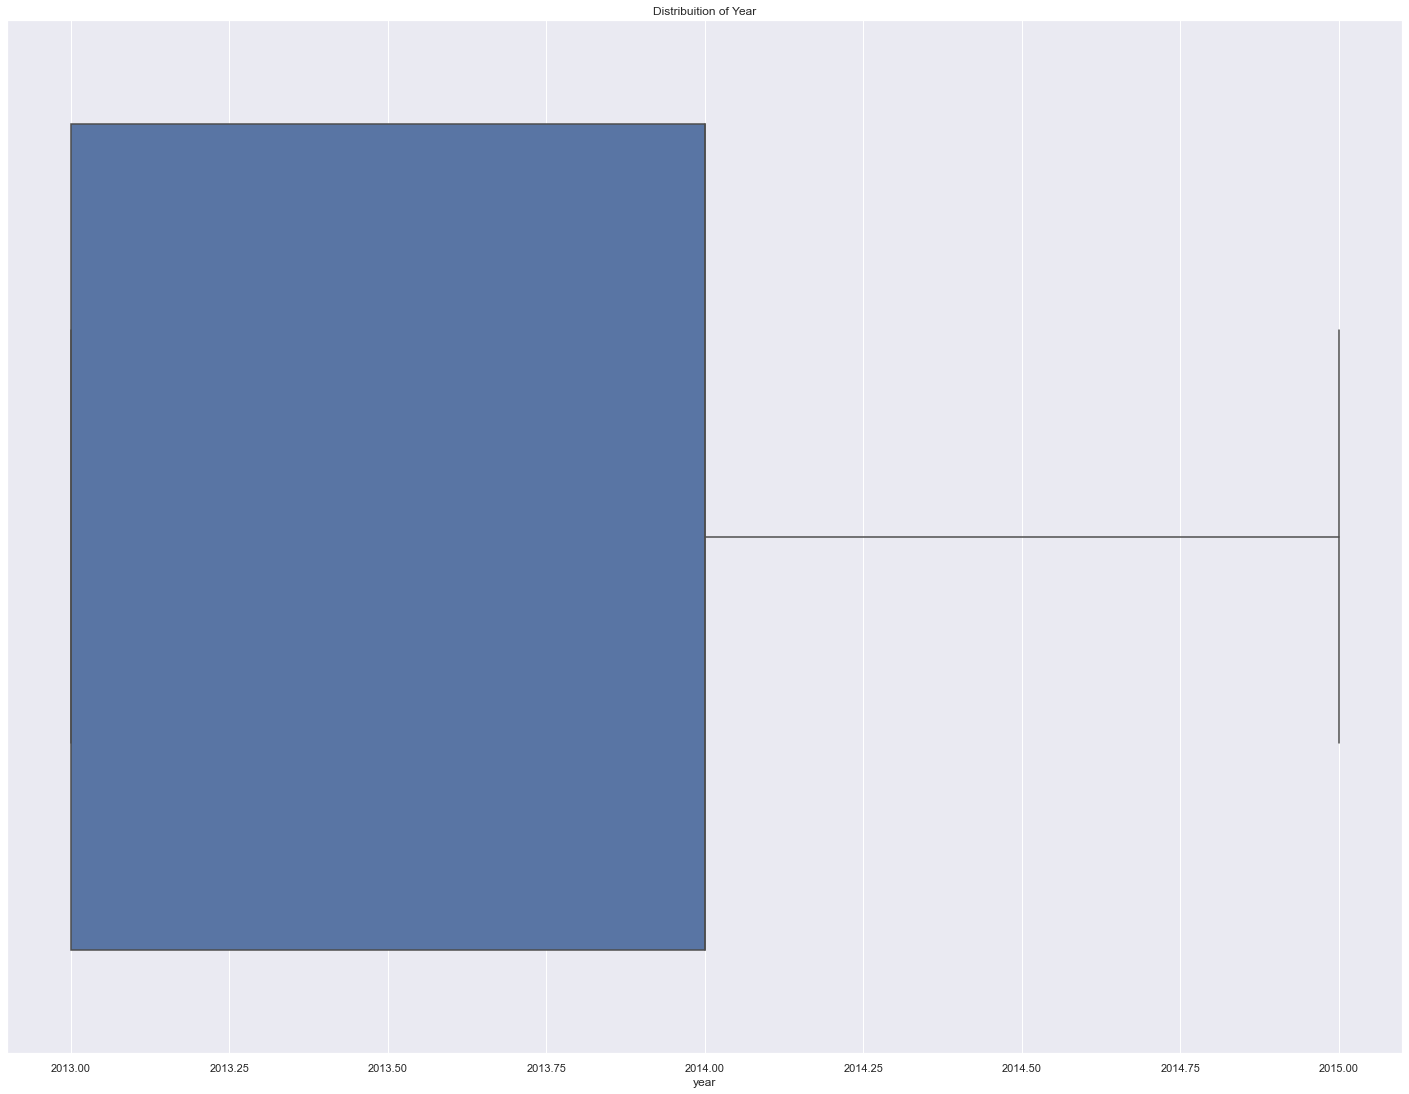

In [60]:
# Creating boxplot in Year column to define scaler
sns.boxplot(df5['year']).set_title('Distribuition of Year');

In [61]:
# Min Max Scaler in Year
mms = MinMaxScaler()
df5['year'] = mms.fit_transform(df5[['year']].values)

# Saving enconding to deploy
pickle.dump(mms, open('C:/Users/MATESANTOS/Documents/Z/0_Estudos/Projetos/Rossmann-Store-Sales/Modelo/parameter/year_scaler.pkl', 'wb'))

## 5.3. Transformation

### 5.3.1. Encoding

In [62]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016


In [63]:
# Applying Encoding (One Hor Enconding) to State_holiday.
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])


# Applying Encoding (Label Encoding) Store_type. To apply the Label Encoding it is necessary import LabelEnconder from sklearn.preprocessing
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# Saving enconding to deploy
pickle.dump(le, open('C:/Users/MATESANTOS/Documents/Z/0_Estudos/Projetos/Rossmann-Store-Sales/Modelo/parameter/store_type_scaler.pkl', 'wb' ))

# Applying Enconding (Ordinal Encoding) to assortment.
# Criar dicionario com os valores da coluna.
assortment_dict = {'basic': 1,'extra': 2,'extended':3}

# Substituindo os valores através do dicionário.
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [64]:
# Seeing the encodings.
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1


### 5.3.2. Response Variable Transformation

In [65]:
# Logging the response variable.
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [66]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. * np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2.* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2.* np.pi/52 ) ) )


df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 Feature Selection

In [67]:
# Make a copy and seeing some rows
df6 = df5.copy()
df6.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


## 6.1 Split dataframe into training and teste dataset

In [68]:
# Droping columns that are not used
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since','competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [69]:
# Search minimum date where sales started
df6[['store', 'date']].groupby('store').min().reset_index()

,store,date
0,1,2013-01-02
1,2,2013-01-02
2,3,2013-01-02
3,4,2013-01-02
4,5,2013-01-02
...,...,...
1110,1111,2013-01-02
1111,1112,2013-01-02
1112,1113,2013-01-02
1113,1114,2013-01-02


In [70]:
# Search maximum date where sales ended
df6[['store', 'date']].groupby('store').max().reset_index()

,store,date
0,1,2015-07-31
1,2,2015-07-31
2,3,2015-07-31
3,4,2015-07-31
4,5,2015-07-31
...,...,...
1110,1111,2015-07-31
1111,1112,2015-07-31
1112,1113,2015-07-31
1113,1114,2015-07-31


In [71]:
# Searching the last 6 weeks for test model.
# In this case we see that we must get the records from 06/19/2015 for the test model, before that for the training model.
df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [72]:
# Training dataset

X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# Teste dataset

X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date: {}'.format(X_test['date'].min()))
print('Test Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2 Boruta as Feature Selector

In [73]:
# Training and teste dataset for boruta

#X_train_n = X_train.drop(['date', 'sales'], axis = 1 ).values
#Y_test_n = Y_train.values.ravel()

# Define RandomForesterRegressor
#rf = RandomForestRegressor(n_jobs = -1)

# Define Boruta
#boruta = BorutaPy(rf, n_estimators ='auto', verbose = 2, random_state = 42).fit(X_train_n, Y_test_n)

### 6.2.1 Best Features from Boruta

In [74]:
#cols_selected = boruta.support_.tolist()

# Best Features
#X_train_fs = X_train.drop(['date','sales'], axis = 1)
#cols_selected_boruta = X_train_fs.iloc[:,cols_selected].columns.to_list()

# Not Selected Boruta

#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3 Manual Feature Selection

In [75]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos']

#columns to add
feat_to_add = ['date', 'sales']

# Final Features.
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7.0 Machine Learning Modelling

## Selection Features

In [76]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Times Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1. Average Model

In [77]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# Prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on = 'store')
yhat_baseline = aux1['predictions']


# Performance
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result                       

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [78]:
# Model
lr = LinearRegression().fit(x_train, Y_train)

# Prediction
yhat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(Y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear Regression Model - Cross Validation

In [79]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [80]:
# Model
lrr = Lasso(alpha = 0.01).fit(x_train, Y_train)

# Prediction
yhat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.70488,0.289106,2744.451735


### 7.3.1 Lasso - Cross Validation

In [81]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [82]:
# Model
rf = RandomForestRegressor(n_estimators=100, n_jobs= -1, random_state=42).fit(x_train, Y_train)

# Prediction
yhat_rf = rf.predict(x_test)

# Performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.548994,0.099664,1007.858486


### 7.4.1 RaNdom Forest Regressor - Cross Validation

In [83]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose = True)
rf_result_cv


KFold Number:5

KFold Number:4

KFold Number:3

KFold Number:2

KFold Number:1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.68 +/- 218.12,0.12 +/- 0.02,1256.33 +/- 318.28


## 7.5. XGBoost Regressor

In [84]:
# Model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimators = 100,
                             eta = 0.01,
                             max_depth = 10,
                             subsample = 0.7,
                             colsample_bytee = 0.9).fit(x_train, Y_train)

# Prediction
yhat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_result

[09:46:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.602213,0.949501,7330.746126


### 7.5.1 XGBoost Regressor - Cross Validation

In [85]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True)
xgb_result_cv


KFold Number:5
[09:47:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number:4
[09:48:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "colsample_bytee" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



KFold Number:3
[09:49:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Pa

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,7047.94 +/- 587.59,0.95 +/- 0.0,7714.01 +/- 688.65


## 7.6. Compare Model's Performance

### 7.6.1. Single Performance

In [86]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.548994,0.099664,1007.858486
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704880,0.289106,2744.451735
0,XGBoost Regressor,6683.602213,0.949501,7330.746126


### 7.6.2. Real Performance - Cross Validation

In [87]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,837.68 +/- 218.12,0.12 +/- 0.02,1256.33 +/- 318.28
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26
0,XGBoost Regressor,7047.94 +/- 587.59,0.95 +/- 0.0,7714.01 +/- 688.65


# 8.0 Hyperparameter Fine Tuning

## 8.1. Random Search

In [88]:
param = {
    'n_estimators':[1500,1700,2500],
    'random_state':[42,62,72],
    'max_depth':[3, 5, 7],
    'max_samples':[0.1, 0.3, 0.5],
        }

MAX_EVAL = 4

In [89]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    # Chosse values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)
    
    # Model
    rf = RandomForestRegressor(n_estimators= hp['n_estimators'], 
                              # n_jobs = hp['n_jobs'],
                               max_depth = hp['max_depth'],
                               max_samples= hp['max_samples'],
                               random_state = hp['random_state']).fit(x_train, Y_train)
    
    # Performance
    result = cross_validation(x_training,4,'Random Forest Regressor', rf, verbose = False)
    final_result = pd.concat([final_result,result])
    
final_result

{'n_estimators': 1500, 'random_state': 42, 'max_depth': 3, 'max_samples': 0.1}
{'n_estimators': 1700, 'random_state': 72, 'max_depth': 7, 'max_samples': 0.5}
{'n_estimators': 2500, 'random_state': 42, 'max_depth': 7, 'max_samples': 0.5}
{'n_estimators': 1700, 'random_state': 42, 'max_depth': 7, 'max_samples': 0.5}


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,1949.05 +/- 144.04,0.29 +/- 0.01,2807.15 +/- 244.3
0,Random Forest Regressor,1825.29 +/- 132.44,0.26 +/- 0.01,2593.63 +/- 222.45
0,Random Forest Regressor,1825.19 +/- 132.95,0.26 +/- 0.01,2593.58 +/- 223.1
0,Random Forest Regressor,1825.02 +/- 132.85,0.26 +/- 0.01,2593.29 +/- 222.95


## 8.2. Final Model

In [100]:
param_tuned = {
    'n_estimators':2500,
    'random_state':42,
    'n_jobs':-1,
    'max_depth':7,
    'max_samples':0.5,
        }

In [103]:
# Model
rf_tuned = RandomForestRegressor(n_estimators = 2500, 
                                 n_jobs= -1,
                                 max_depth = 7,
                                 max_samples = 0.5,
                                 random_state = 42).fit(x_train, Y_train)

# Prediction
yhat_rf_tuned = rf_tuned.predict(x_test)

# Performance
rf_result_tuned = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf_tuned))
rf_result_tuned

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,1770.456937,0.265087,2536.223247


# 9.0 Translation and Interpretation of the error

In [104]:
df9 = X_test[cols_selected_boruta_full]

# Rescale

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_rf_tuned)

## 9.1. Business Performance

In [123]:
# Sum of predictions

df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE

df9_aux1 = df9[['store','sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAE'})
df9_aux2 = df9[['store','sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store' )
df92 = pd.merge(df91, df9_aux3, how = 'inner', on ='store')


# Scenarios

df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# Order Columns

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

df92.sort_values('MAPE', ascending=True).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
603,604,244324.327798,243780.778385,244867.877211,543.549413,0.074296
634,635,210354.897980,209875.400794,210834.395166,479.497186,0.075516
935,936,244672.004612,244162.551310,245181.457913,509.453301,0.078878
427,428,234966.922731,234406.368608,235527.476854,560.554123,0.079062
765,766,251683.893284,251152.925859,252214.860708,530.967425,0.080552


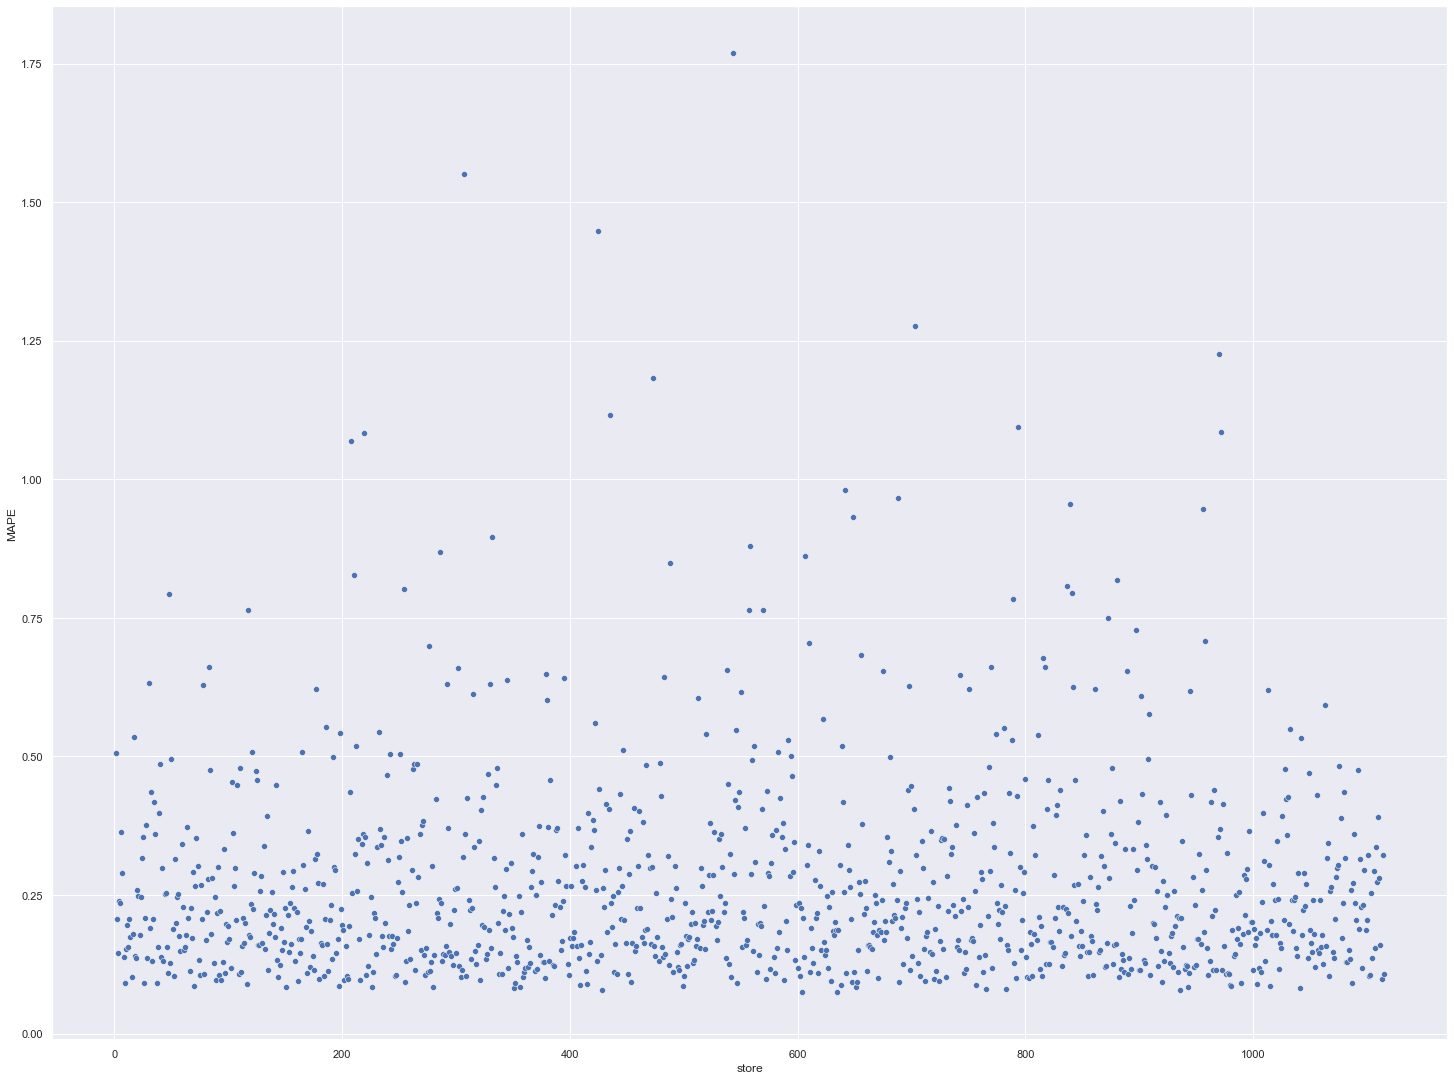

In [106]:
sns.scatterplot(x = 'store', y = 'MAPE', data = df92);

## 9.2. Total Performance

In [134]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index(). rename(columns ={'index': 'Scenario', 0: 'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)

In [132]:
df93.rename(columns={'Scenario':'SCENARIO', 'Values':'VALUES'}, inplace=True)
df93

,SCENARIO,VALUES
0,predictions,"R$ 268,804,261.00"
1,worst_scenario,"R$ 266,830,308.07"
2,best_scenario,"R$ 270,778,213.92"


## 9.3. Machine Learning Performance

In [129]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

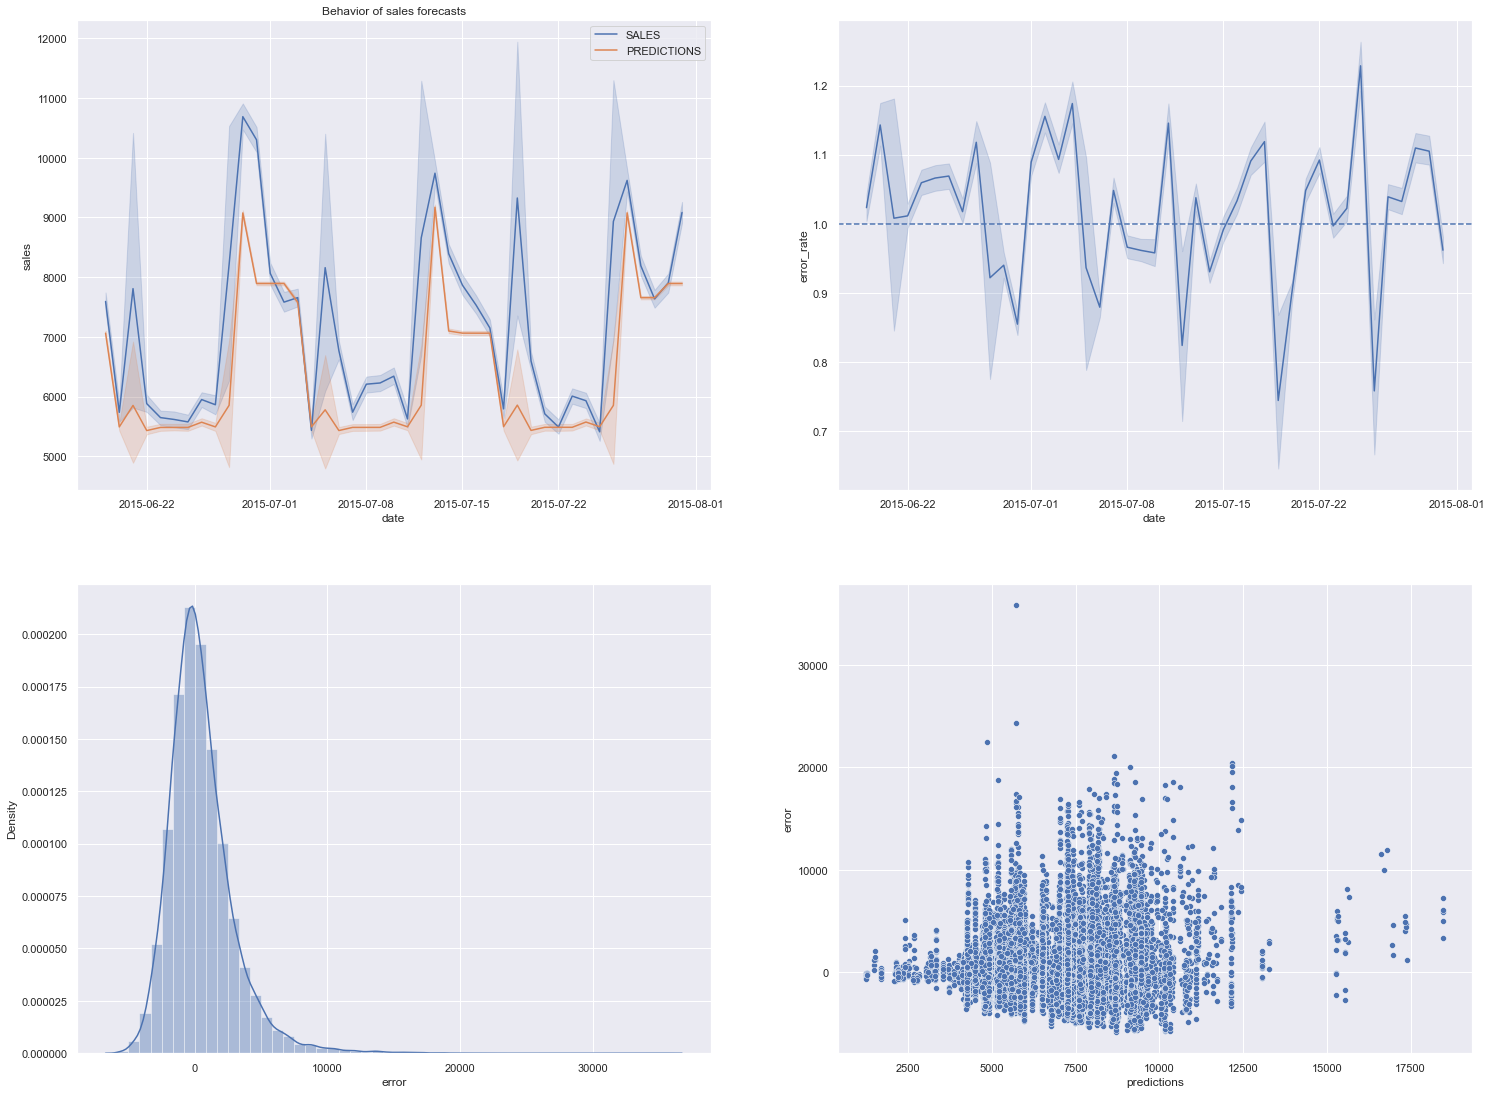

In [136]:
plt.subplot(2, 2, 1)
sns.lineplot( x = 'date', y = 'sales', data = df9, label = 'SALES');
sns.lineplot( x = 'date', y = 'predictions', data = df9, label = 'PREDICTIONS').set_title('Behavior of sales forecasts');

plt.subplot(2, 2, 2)
sns.lineplot( x = 'date', y = 'error_rate', data = df9);
plt.axhline( 1, linestyle = '--')


plt.subplot(2, 2, 3)
sns.distplot(df9['error']);


plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error']);

# 10.0 Final Result

With the metrics and parameters used in this first interaction of the cycle, we see that we have three scenarios:

**Predictions:** It was predicted for the next six weeks a total sales of $ 268,804,261.

**Best Scenario:** Based on the prediction, we have a best scenario (in total) with $ 270,778,213.92, an increase of 0.73% compared to the prediction.

**Worst Scenario:** For the worst scenario we have a value of $ 266,830,308.07, a drop of 0.74% in relation to the prediction.

In [133]:
df93

,SCENARIO,VALUES
0,predictions,"R$ 268,804,261.00"
1,worst_scenario,"R$ 266,830,308.07"
2,best_scenario,"R$ 270,778,213.92"


For the next design interactions, more parameters for the models will be evaluated and their behavior in relation to performance will be analyzed, in addition to the derivation of other features for better learning of the models.

In [ ]:
pip install --upgrade --force-reinstall --no-cache-dir jupyter